<a href="https://colab.research.google.com/github/lawbaker/PythonOR2021/blob/main/04_Intro_to_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A not very scary introduction to Machine Learning

### Lawrence Baker









## Acknowledgements

Parts of this session have been adapted from one run by Alistair Johnson, who is part of the Institute for Medical Engineering & Science at MIT.

This session was originally part of a datathon in Chile, given with Braiam Restrepo

## Google Colaboratory

This is a Google Colaboratory notebook. Think of it as a combination of a Google doc and a Jupyter Notebook. Essentially it allows you to run python code without having to download anything except a browser (we'd recommend that you run in Chrome). It's also very easy to share and modify.

## What are the takeways from this session?

This session will introduce some basic machine learning concepts and algorithms in the context of small, pre-cleaned datasets.

Here's what I want you to takeaway:
* Many machine learning algorithms are very simple, especially if you visualize what they are doing.
* Running algorithms need be no more complicated than running a linear regression.
* The basic structure of a machine learning problem. Train, validate, test.

## Why might this session be useful?

* Understanding what someone means when they say they've used a machine learning algorithm.
* Machine learning can often quickly answer prediction questions with basic models
* You can take this code if ever you need a reference

Generally speaking in policy analysis, because we are concerned with causality, we normally don't touch these ML algorithms, which are about prediction. 

In problems where we care about prediction (like fitting propensity scores), ML algorithms can be much better than regressions.

## What are we covering?

We're only going to look at classification  problems, when you want to tell what 'type' something is. For instance that could be, who will default on loan, who will click on an ad, or whether someone will make an insurance claim.

Unsupervised learning - uncovering data structures
* K-means clustering

Supervised learning - predicing types
* Support Vector Machines (SVM)
* Decision-trees
* Random forests

## Let's get started!

To run a cell, put your cursor inside the cell and press 'Shift' + 'Enter', or click the little 'play' button on the top left of the cell. This notebook runs in the cloud, so you should be able to run along locally if you want (though if you run out of order then you might get errors).

## Packages

Colab also comes ready with many pre-installed packages. We'll import these now, as they are invaluable for handling data. The most important ones are particular:

* **NumPy** - mathematical functions and support for arrays
* **Pandas** - support for data structures and data analysis
* **scikit-learn** - the catch-all machine learning package for python
* **Matplotlib** - a ubiquitous python plotting library. **Seaborn** is a data visualisation library which builds on Matplotlib

Sometimes we want to import part of a package, or give part of a package an easy to use name. This can be done with the syntax:

```
import X
from X import Y
from sklearn.svm import SVC
```

For example, one of the (many) functions we import from sklearn is the function SVC, which stands for Support Vector Classifier. If, in the code we call

```
SVC()
```
Then python knows what we are refering to because we have imported it here.


In [ ]:
from __future__ import print_function

import errno
import os

import numpy as np
import pandas as pd
import seaborn as sns
import collections

from sklearn import tree, ensemble, metrics
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, pairwise_distances, pairwise_distances_argmin
from sklearn.cluster import KMeans
from matplotlib.ticker import FuncFormatter


from sklearn import datasets
import pydotplus

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches

# used to display trees and images
from google.colab import files
from IPython.display import Image

%matplotlib inline
plt.style.use('ggplot')
sns.set(style="ticks")

plt.rcParams.update({'font.size': 20})

## Functions

Here I define some functions which will make our lives easier later. These are essentially all plotting functions, needed for visualization but not the machine-learning itself.

In [ ]:
def plot_line(xmin, xmax, y, g, color):
    """Plots a line when given a start co-ordinate, gradient and end x-value"""
    plt.plot([xmin, xmax], [y, y+(xmax-xmin)*g], color=color, linestyle='-', linewidth=2)
   
  
def shortest_distance(xp, yp, xmin, y, g):
    """Finds the shortest distance between a plot and a line"""
    a=g
    b=-1
    c=y - g*xmin
    d = abs((a * xp + b * yp + c)) / (np.sqrt((a*a) + (b*b)))
                                   
    return d
  
  
def make_colormap(seq):
    """Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    """
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return matplotlib.colors.LinearSegmentedColormap('CustomMap', cdict)

# set up a custom colour map custom colormap
#e58139f9 - orange
#399de5e0 - to blue
s = list()

lo = np.array(matplotlib.colors.to_rgb('#e5813900'))
hi = np.array(matplotlib.colors.to_rgb('#399de5e0'))

for i in range(255):
    s.append( list((hi-lo)*(float(i)/255)+lo) )
cm = make_colormap(s)
  
def plot_svc_decision_function(model, ax=None, plot_support=True, cm=cm):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 500)
    y = np.linspace(ylim[0], ylim[1], 500)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    Z = model.predict(np.c_[X.ravel(), Y.ravel()])
    Z = Z.reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contourf(X, Y, P, colors='grey',
               levels=[-1, 1], alpha=0.3)
    ax.contour(X, Y, P, colors='grey', levels=[0])
    ax.contourf(X, Y, Z, cmap=cm, alpha=0.3)
    
    # plot support vectors
    if plot_support:
        sns.scatterplot(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='r', alpha=0.2);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
def confusion_heatmap(y_true, y_pred, title, plot=True):
    """Plot a confusion matrix"""
    cnf_matrix = metrics.confusion_matrix(y_true, y_pred)
    accuracy=(cnf_matrix[0][0]+cnf_matrix[1][1])/cnf_matrix.sum()
    sensitivity=cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0])
    specificity=cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1])
    
    if plot==True:
        fig, ax = plt.subplots(figsize=(6,4))
        plt.xticks([0,1])
        plt.yticks([1,0])
        # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g', cbar=False)
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        plt.title('Confusion matrix %s' %title, fontsize=15,y=1.1)
        plt.show()
    
        print("Accuracy is",  round(accuracy*100,2),"%")
        print("Sensitivity is",  round(sensitivity*100,2),"%")
        print("Specificity is",  round(specificity*100,2),"%")
    
    return
  
  
def plot_tree_pred_2d(mdl, X, y, ax, cm=cm):
    """Used to plot the prediction regions in a 2D plot, 
    based on scikit-learn tutorial plot_iris.html"""
    
    # get minimum and maximum values
    x0_min = X.iloc[:, 0].min()
    x0_max = X.iloc[:, 0].max()
    x1_min = X.iloc[:, 1].min()
    x1_max = X.iloc[:, 1].max()
    
    #add some space round the edge
    x0_min -= abs(x0_min)*0.05
    x0_max += abs(x0_min)*0.05
    x1_min -= abs(x1_min)*0.05
    x1_max += abs(x1_min)*0.05

    xx, yy = np.meshgrid(np.linspace(x0_min, x0_max, 500),
                         np.linspace(x1_min, x1_max, 500))

    Z = mdl.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # plot the contour - colouring different regions
    cs = plt.contourf(xx, yy, Z, cmap=cm, alpha=0.3)
    

    # plot the individual data points - colouring by the *true* outcome
    color = y.ravel()
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=color, edgecolor='k', linewidth=2,
                marker='o', s=60, cmap=cm)
    plt.xlim(x0_min, x0_max)
    plt.ylim(x1_min, x1_max)
        
def create_graph(mdl, cmap=None):
    """Uses graphviz to plot a graph of a decision tree"""
    # cmap is a colormap
    # e.g. cmap = matplotlib.cm.coolwarm( np.linspace(0.0, 1.0, 256, dtype=float) )
    tree_graph = tree.export_graphviz(mdl, out_file=None,
                             feature_names=feat, 
                             filled=True, rounded=True)
    graph = pydotplus.graphviz.graph_from_dot_data(tree_graph)
    
    # get colormap
    if cmap:
        # remove transparency
        if cmap.shape[1]==4:
            cmap = cmap[:,0:2]
        
        nodes = graph.get_node_list()
        for node in nodes:
            if node.get_label():
                # get number of samples in group 1 and group 2
                num_samples = [int(ii) for ii in node.get_label().split('value = [')[1].split(']')[0].split(',')]

                # proportion that is class 2
                cm_value = float(num_samples[1]) / float(sum(num_samples))
                # convert to (R, G, B, alpha) tuple
                cm_value = matplotlib.cm.coolwarm(cm_value)
                cm_value = [int(np.ceil(255*x)) for x in cm_value]
                color = '#{:02x}{:02x}{:02x}'.format(cm_value[0], cm_value[1], cm_value[2])
                node.set_fillcolor(color)

    Image(graph.create_png())
    return graph
  
  
def plot_roc_curve(model, X, y, y_pred_prob=None, title="", plot=True, sample_weight=None):
    """Plot a ROC curve and calculate the AUC"""
    sns.set(style="ticks")
    if model !=None:
      y_pred_prob=model.predict_proba(X)[:,1]
    else:
      y_pred_prob=y_pred_prob
    fpr, tpr, redun=roc_curve(y, y_pred_prob, sample_weight=sample_weight)
    roc_auc=roc_auc_score(y, y_pred_prob, sample_weight=sample_weight)
    if plot==True:
        fig, ax = plt.subplots(figsize=(6,4))
        lw = 2
        plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title("ROC Curve %s" %title, fontsize=15)
        plt.legend(loc="lower right")
        plt.show()
    return

## Dataset


### Loading the data

Next, let's load our dataset. To explain methods we'll use an adapted version of a very simple (and famous) dataset. Edgar Anderson collected data from Iris flowers, such as their petal lengths. This data was was later used by Fisher to demonstrate Linear Discriminant Analysis could correctly classify the Iris species.

The code below:
* loads in the dataset
* converts the dataset into a pandas dataframe for easier handling
* prints out a brief description

In [ ]:
# load the dataset (this is already present in a package, which is why you don't need to download anything)
iris_dataset = datasets.load_iris()
# Print out the dataset description which is shown below
#print(iris_dataset['DESCR'])

# Turn the dataset objects into a nice dataframe
iris = pd.DataFrame(data=iris_dataset['data'])
iris.columns=iris_dataset['feature_names']
iris['target']=iris_dataset['target']

<img src='https://miro.medium.com/max/1000/1*Hh53mOF4Xy4eORjLilKOwA.png'>

In [ ]:
iris

sepal length (cm)  sepal width (cm)  ...  petal width (cm)  target
0                  5.1               3.5  ...               0.2       0
1                  4.9               3.0  ...               0.2       0
2                  4.7               3.2  ...               0.2       0
3                  4.6               3.1  ...               0.2       0
4                  5.0               3.6  ...               0.2       0
..                 ...               ...  ...               ...     ...
145                6.7               3.0  ...               2.3       2
146                6.3               2.5  ...               1.9       2
147                6.5               3.0  ...               2.0       2
148                6.2               3.4  ...               2.3       2
149                5.9               3.0  ...               1.8       2

[150 rows x 5 columns]

We can see that our dataset has 5 columns, 4 of which are features and one of which is a 'target'. There are 150 records (rows) in our dataset, in this case 50 of each of 3 different iris varieties.

To make our data easier to visualise, we can reduce the number of dimensions. The number of features defines the dimensionality of the problem. 3 features requires visualisation in 3-D space, 4 features in 4-D space and so on. Although the techniques we go through in this section scale into n-dimensional space, it's much easier to visualise results in 2-D space, so we will limit this dataset to 2-D space.

Firstly, let's imagine the most simple scenario, one in which have only the measurements, but no other information (no outcome variable)

## Unsupservised Learning: K-means clustering

### Question: How many types of flowers are there in my dataset?

### Goal: Look at the structure of our data, find a way to group like measurements together

Some datasets might not come labelled, let's imagine for a moment that all we had done was measure some irises, but we didn't know how many different varieties there were, or which flowers were a certain variety. 

The first thing to do with almost any problem is to visualise the data we have. We can plot the data using a scatter, here I show 2 of the 4 features, because visualisation is easier in two dimensions. 3 features requires a 3 dimensional graphs, it's difficult to show more than 3 features.

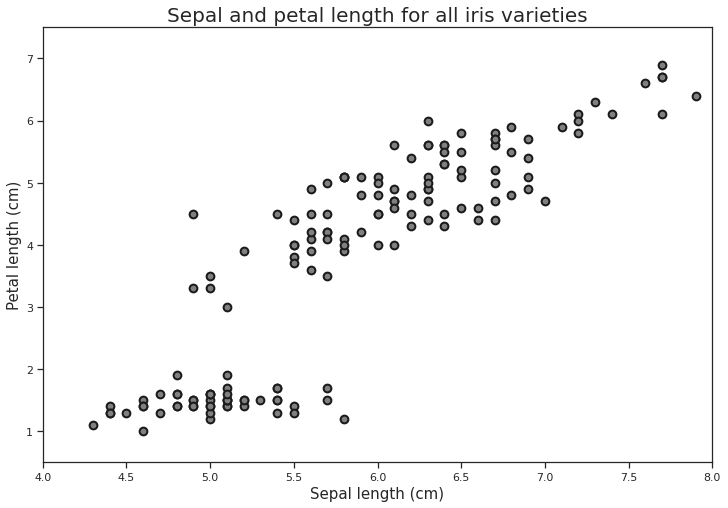

In [ ]:
#plot data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= 'grey', edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.xlim(4,8)
plt.ylim(0.5,7.5)
plt.title("Sepal and petal length for all iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### What would we do?

When thinking about an algorithm, a good place to start is often asking what you would do, and then look back and inspect how you made that decision

#### With 2 groups?

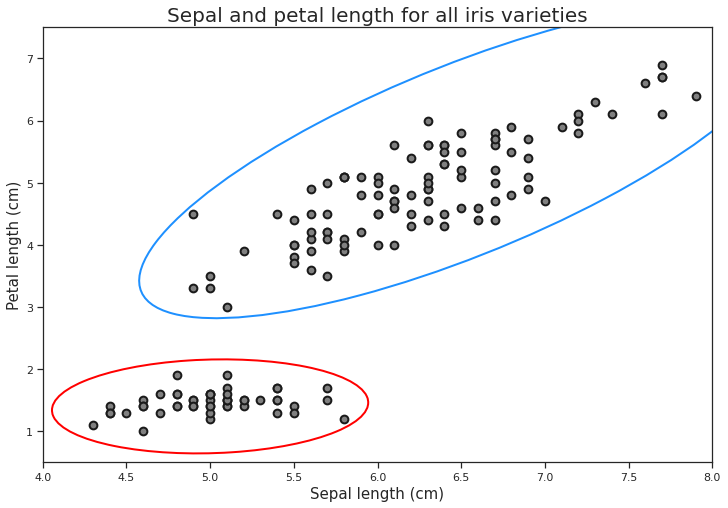

In [ ]:
#plot data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= 'grey', edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)

#plot patches
ellipse1 = patches.Ellipse(xy = (5,1.4), width = 1.9, height = 1.5, angle = 10, 
                           color = 'red', fill = None, lw = 2)

ellipse2 = patches.Ellipse(xy = (6.5,5.35), width = 6, height = 2.1, angle = 55, 
                           color = 'dodgerblue', fill = None, lw = 2)

ax.add_patch(ellipse1)
ax.add_patch(ellipse2)

plt.xlim(4,8)
plt.ylim(0.5,7.5)
plt.title("Sepal and petal length for all iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

#### With 3 groups?

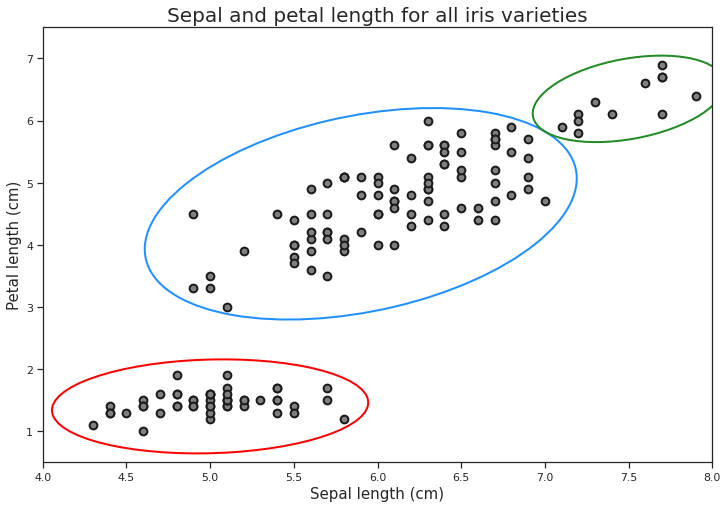

In [ ]:
#plot data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= 'grey', edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)

#plot patches
ellipse1 = patches.Ellipse(xy = (5,1.4), width = 1.9, height = 1.5, angle = 10, 
                           color = 'red', fill = None, lw = 2)

ellipse2 = patches.Ellipse(xy = (5.9,4.5), width = 3.6, height = 2.3, angle = 65, 
                           color = 'dodgerblue', fill = None, lw = 2)

ellipse3 = patches.Ellipse(xy = (7.5,6.35), width = 1, height = 1.5, angle = -30, 
                           color = 'forestgreen', fill = None, lw = 2)

ax.add_patch(ellipse1)
ax.add_patch(ellipse2)
ax.add_patch(ellipse3)

plt.xlim(4,8)
plt.ylim(0.5,7.5)
plt.title("Sepal and petal length for all iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### K-means algorithm

Clustering describes a group of methods which are seeking to uncover patterns in unlabelled data. If you look at the dataset above, then you might already think you can spot a pattern, there seems to be two completely distinct groups of points, perhaps they are separate varieties?

A particularly simple clustering method is k-means clustering, which uses this iterative method:


1.   Decide on your number of clusters, generate that many points, one for each cluster. These points are start for the centroids (centre) of the cluster
2.   For every data point, calculate the distance to each of the centroids
3.   Assign each data point to the cluster with the clostest centroid
4.   Recalculate the centroid for each cluster by averaging the position of every point contained in that cluster
5.   Repeat steps 3 and 4 until the centroids have converged (some times this can take many iterations)



## Running K-means

Let's look at what happens we use K-means clustering on our dataset with two clusters. Again, I am only using 2 of the 4 features, because this makes the data easier to visualise, but k-means does scale up to data with more dimensions.

In [ ]:
# Set the number of clusters
K = 2

# Get input data for K-means
X_clustering = iris[["sepal length (cm)", "petal length (cm)"]]

# Create kmeans model
kmeans = KMeans(n_clusters=K, random_state=0)
# Fit kmeans
kmeans=kmeans.fit(X_clustering)

# Get the results
classes = kmeans.labels_
centroids = kmeans.cluster_centers_

### Plotting K-means

Now we can plot the results, note how the clusters have separated points on either side of the gap.

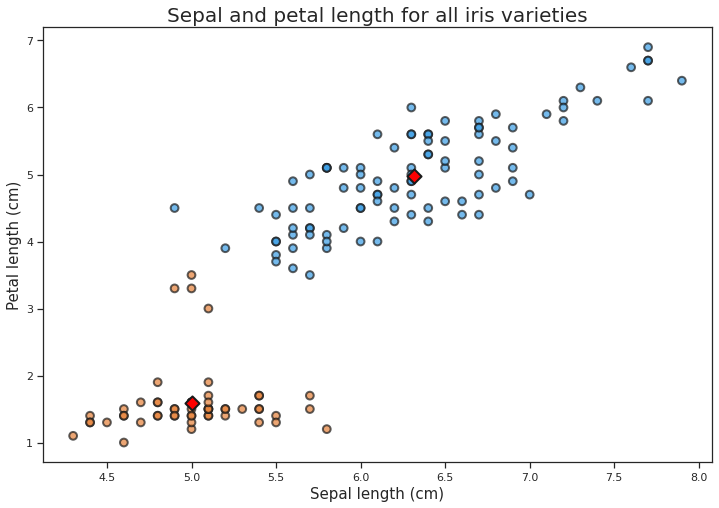

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

#plot data (with colors representing classes)
plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= classes, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm, alpha = 0.7)

#plot each centroid
for centroid in centroids:
  plt.scatter(centroid[0], centroid[1], c= 'red', marker='D', edgecolor='k',
                linewidth=2, s=100)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.title("Sepal and petal length for all iris varieties", fontsize=20)
plt.show()

### Plotting convergence

It can be hard to visualise how the centroids move. Convergence of these centroids is shown below.

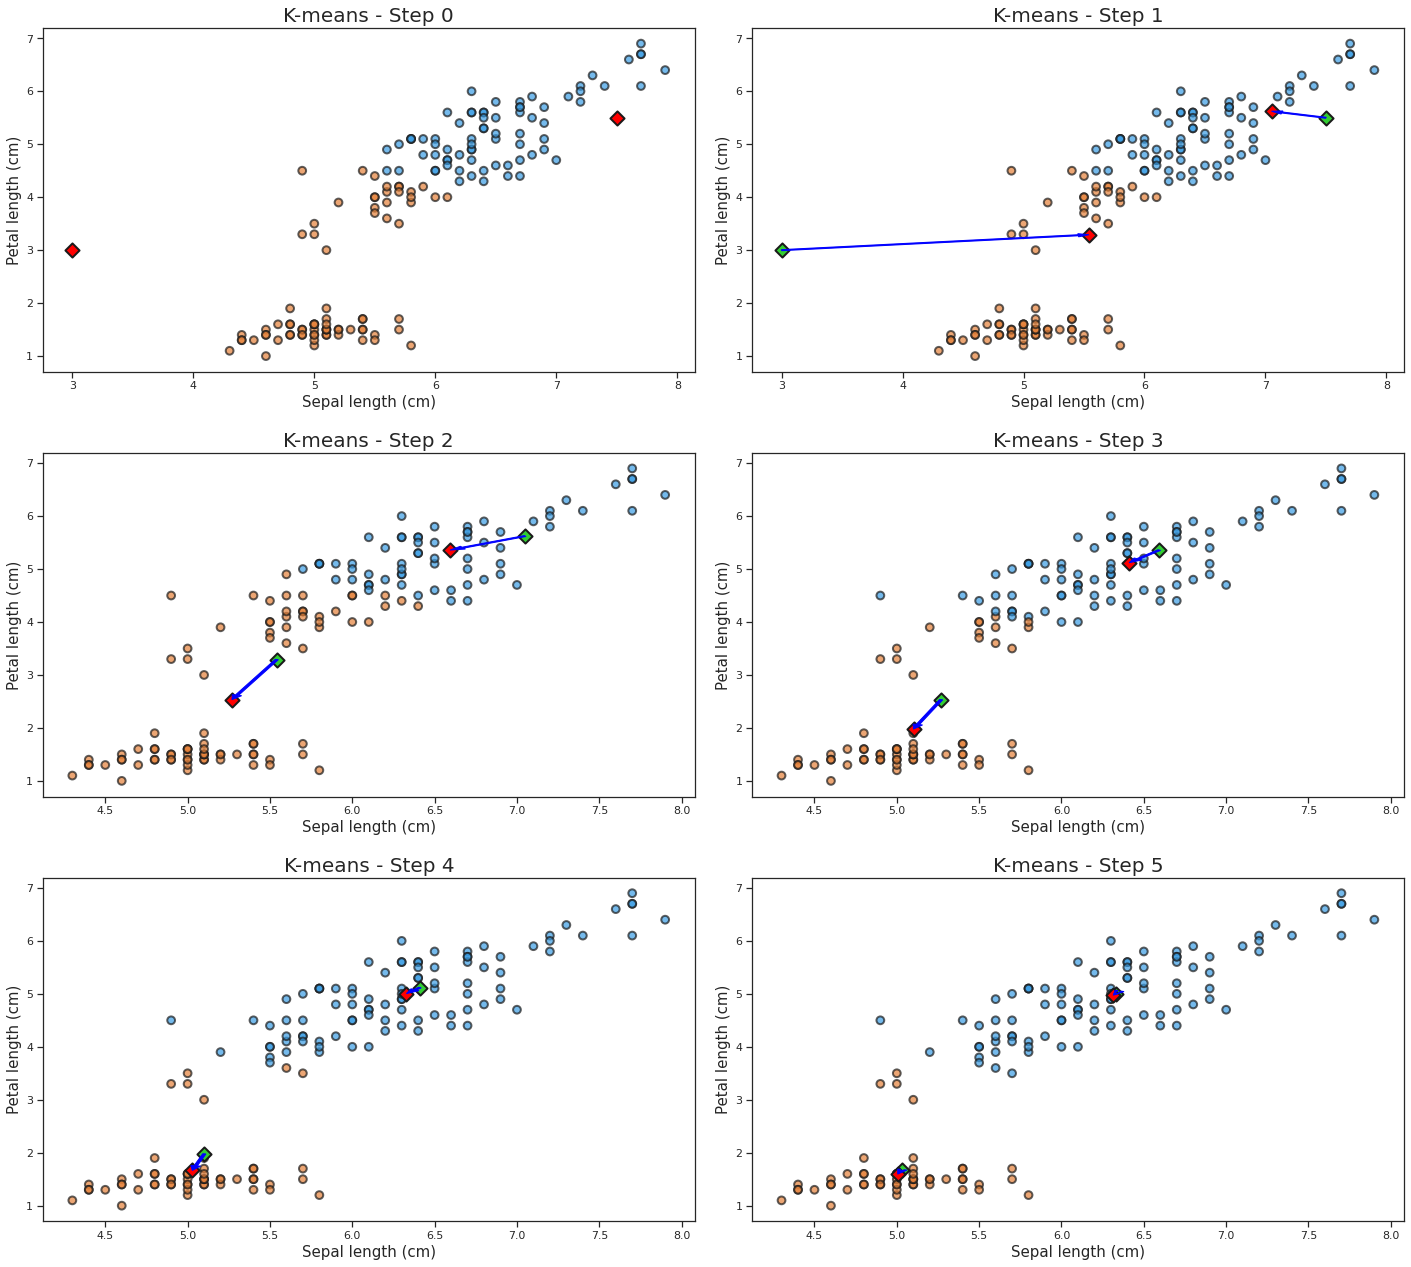

In [ ]:
#initialise variables
K=2
fig = plt.figure(figsize=(20,18))
old_centroids=[0,0]
classes_list = []

initial_position=np.array([[5.5,3],[7.5,3]])

#run a loop with a different number of maximum iterations
for i in range(0,6):

  plt.subplot(3, 2, i+1)

  if i != 0:
    kmeans = KMeans(n_clusters=K, max_iter=i, n_init=1, random_state=5, init=initial_position).fit(X_clustering)
    classes = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    #plot points
    plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= classes_list[i-1], edgecolor='k',
                    linewidth=2, marker='o', s=60, cmap=cm, alpha = 0.7)
  
  else:
    classes = pairwise_distances_argmin(X = iris[["sepal length (cm)", "petal length (cm)"]], Y = initial_position.T)
    classes = 1-classes   
    #plot points
    plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= classes, edgecolor='k',
                    linewidth=2, marker='o', s=60, cmap=cm, alpha = 0.7)

  #plot the new and old centoids
  for centroid, old_centroid, initial in zip(centroids, old_centroids, np.flip(initial_position.T)):
    if i > 1:
      plt.scatter(old_centroid[0], old_centroid[1], c= 'limegreen', marker='D', edgecolor='k',linewidth=2, s=100)
    
    if i != 0:
      plt.scatter(centroid[0], centroid[1], c= 'red', marker='D', edgecolor='k',
                  linewidth=2, s=100)
    else:
      plt.scatter(initial[0], initial[1], c= 'red', marker='D', edgecolor='k',
                  linewidth=2, s=100)
      
    if i == 1:
      plt.scatter(initial[0], initial[1], c= 'limegreen', marker='D', edgecolor='k',
                  linewidth=2, s=100)

    #plot an arrow between them
    if i > 1:
      plt.arrow(old_centroid[0], old_centroid[1], centroid[0]-old_centroid[0], centroid[1]-old_centroid[1], 
                color='blue', width=0.02, length_includes_head=True)
    elif i == 1:
      plt.arrow(initial[0], initial[1], centroid[0]-initial[0], centroid[1]-initial[1], 
                color='blue', width=0.02, length_includes_head=True)


  #update the new centroids to be the old centroids
  old_centroids=centroids
  #save the classes in a list for later
  classes_list.append(classes)

  #get the charts looking nice
  plt.ylabel("Petal length (cm)", fontsize=15)
  plt.xlabel("Sepal length (cm)", fontsize=15)
  plt.title("K-means - Step %i" %i, fontsize=20)

fig.tight_layout()
plt.show()

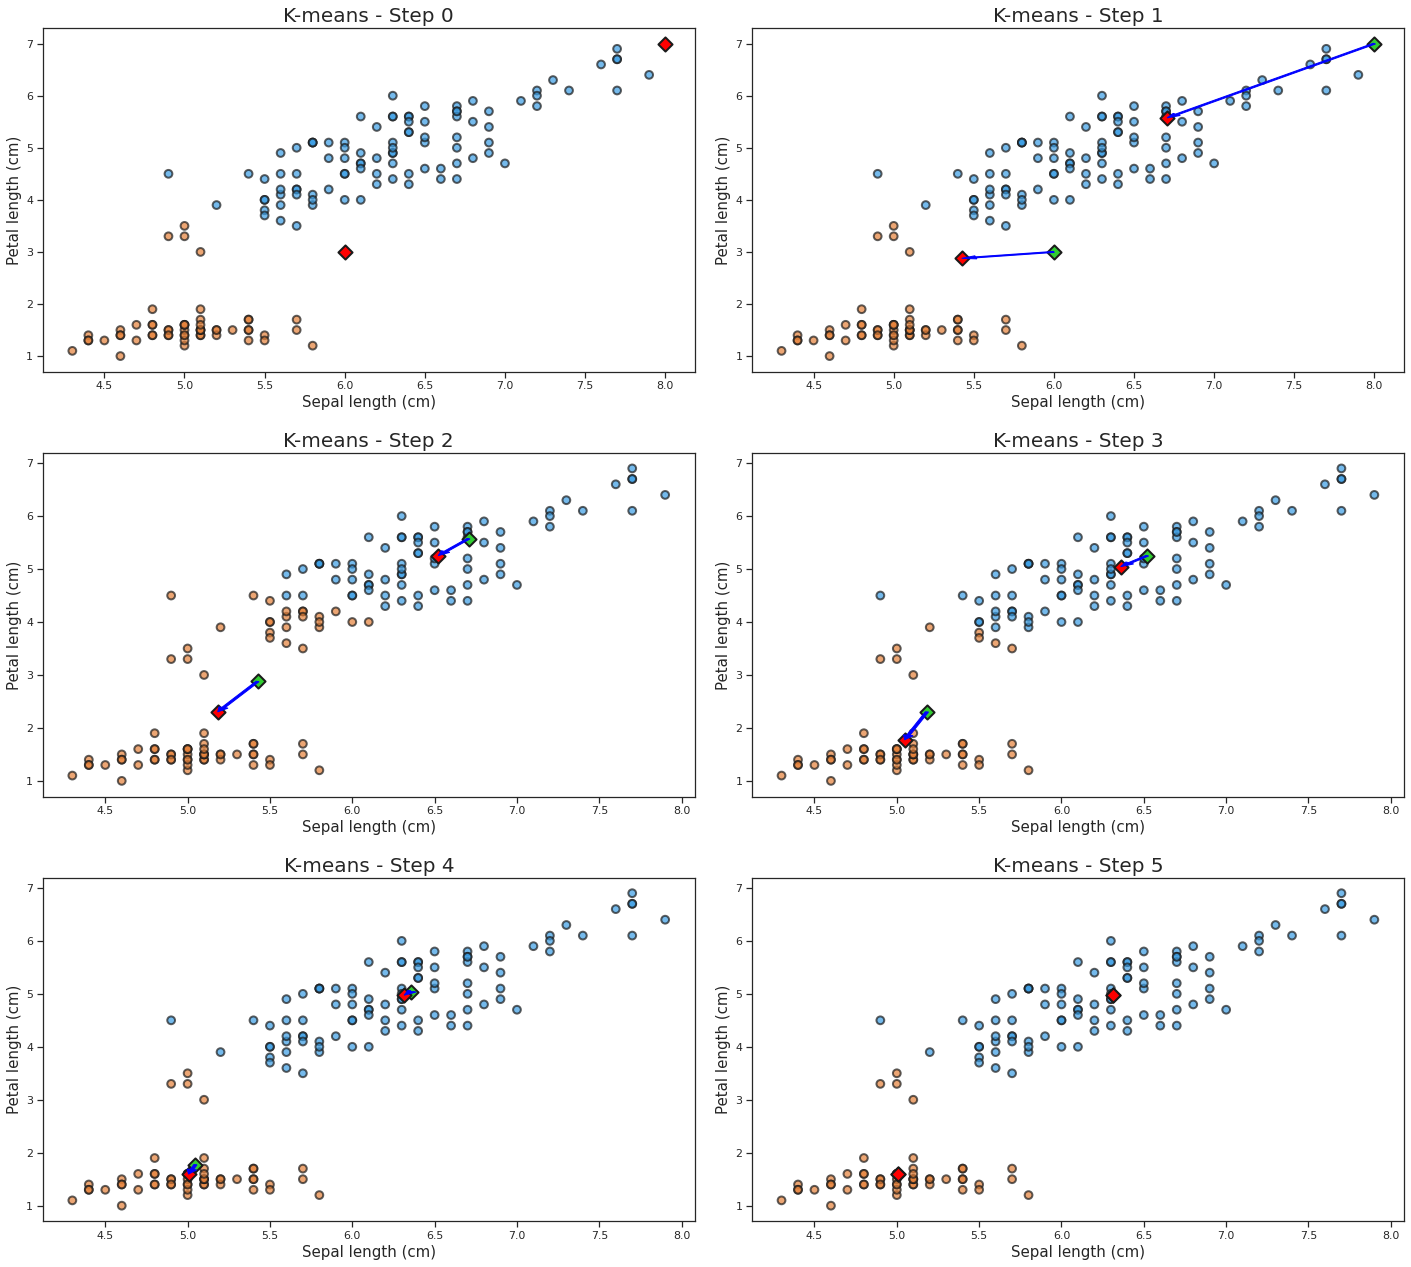

In [ ]:
#initialise variables
K=2
fig = plt.figure(figsize=(20,18))
old_centroids=[0,0]
classes_list = []

initial_position=np.array([[7,3],[8,6]])
#run a loop with a different number of maximum iterations
for i in range(0,6):

  plt.subplot(3, 2, i+1)

  if i != 0:
    kmeans = KMeans(n_clusters=K, max_iter=i, n_init=1, random_state=5, init=initial_position).fit(X_clustering)
    classes = kmeans.labels_
    centroids = kmeans.cluster_centers_
    
    #plot points
    plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= classes_list[i-1], edgecolor='k',
                    linewidth=2, marker='o', s=60, cmap=cm, alpha = 0.7)
  
  else:  
    #plot points
    plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= classes, edgecolor='k',
                    linewidth=2, marker='o', s=60, cmap=cm, alpha = 0.7)

  #plot the new and old centoids
  for centroid, old_centroid, initial in zip(centroids, old_centroids, np.flip(initial_position.T)):
    if i > 1:
      plt.scatter(old_centroid[0], old_centroid[1], c= 'limegreen', marker='D', edgecolor='k',linewidth=2, s=100)
    
    if i != 0:
      plt.scatter(centroid[0], centroid[1], c= 'red', marker='D', edgecolor='k',
                  linewidth=2, s=100)
    else:
      plt.scatter(initial[0], initial[1], c= 'red', marker='D', edgecolor='k',
                  linewidth=2, s=100)
      
    if i == 1:
      plt.scatter(initial[0], initial[1], c= 'limegreen', marker='D', edgecolor='k',
                  linewidth=2, s=100)

    #plot an arrow between them
    if i > 1:
      plt.arrow(old_centroid[0], old_centroid[1], centroid[0]-old_centroid[0], centroid[1]-old_centroid[1], 
                color='blue', width=0.02, length_includes_head=True)
    elif i == 1:
      plt.arrow(initial[0], initial[1], centroid[0]-initial[0], centroid[1]-initial[1], 
                color='blue', width=0.02, length_includes_head=True)


  #update the new centroids to be the old centroids
  old_centroids=centroids
  #save the classes in a list for later
  classes_list.append(classes)

  #get the charts looking nice
  plt.ylabel("Petal length (cm)", fontsize=15)
  plt.xlabel("Sepal length (cm)", fontsize=15)
  plt.title("K-means - Step %i" %i, fontsize=20)

fig.tight_layout()
plt.show()

### How many groups?

Perhaps the biggest question you should ask when deploying k-means clusters, is how many clusters you should have. We chose two, but this was arbitary. One method is to look at intertia scores for each number of clusters and see by how much they decrease.

Inertia is the sum of the squared distances from each point to the centre of its cluster. It will always decrease as more clusters are added, but if the clusters are not useful then it won't decrease by very much. The 'elbow method' involves plotting the intertia for different numbers of clusters and looking for when the there is little benefit from adding the new cluster, let's do that here:

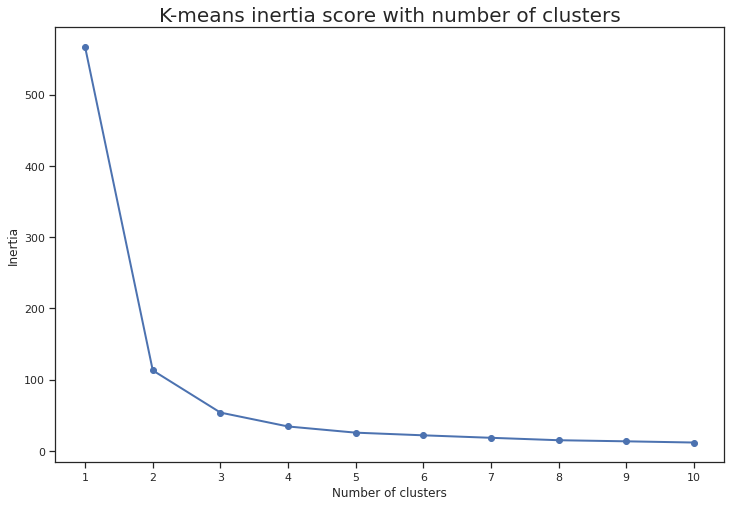

In [ ]:
#create an empty list of scores
inertia_scores=[]
max_n = 10
#run the algoirthm 10 times and save the scores
for i in range(1, max_n +1):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X_clustering)
  inertia_scores.append(kmeans.inertia_)
  
#plot scores
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.plot(range(1, 11), inertia_scores, marker='o', lw= 2)
plt.title("K-means inertia score with number of clusters", fontsize=20)
plt.xticks(range(1, max_n +1))
plt.ylabel("Inertia")
plt.xlabel("Number of clusters")
plt.show()

As we can see, after 3 clusters have been used the decrease in inertia for each new cluster drops off strongly. This would lead us towards using 3 clusters. Let's see what this looks like and plot it side by side with the reality in our data:

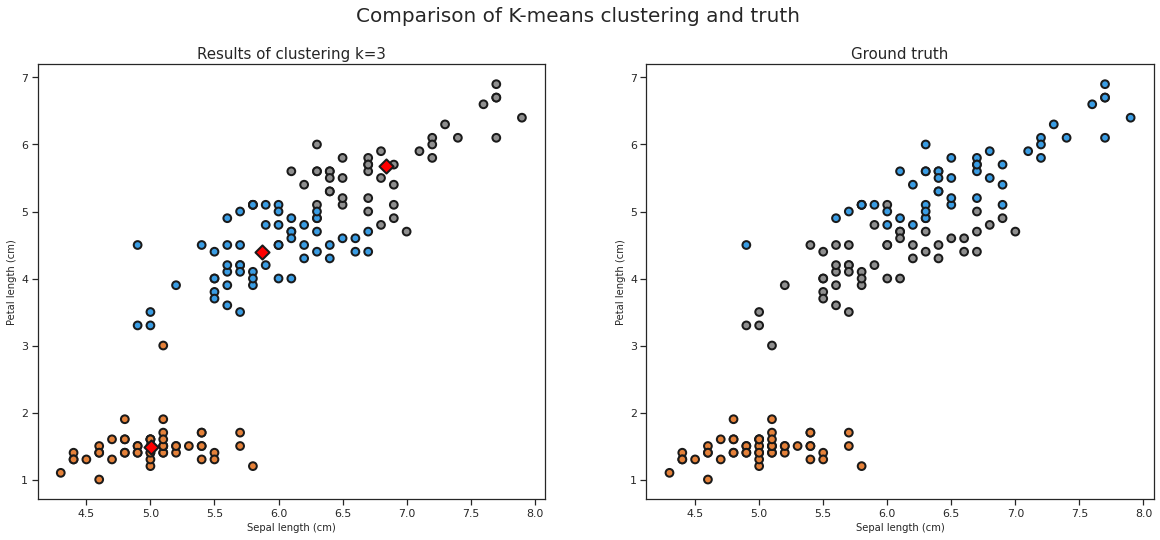

In [ ]:
# set the number of clusters
K = 3

# input data to fit K-means
X_clustering = iris[["sepal length (cm)", "petal length (cm)"]]

# fit kmeans
kmeans = KMeans(n_clusters=K, random_state=0).fit(X_clustering)

classes = kmeans.labels_
centroids = kmeans.cluster_centers_


fig, axs = plt.subplots(1, 2, figsize = (20, 8))
gridspec.GridSpec(1,2)

#plot results
plt.subplot2grid((1,2), (0,0))
plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= classes, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
for centroid in centroids:
  plt.scatter(centroid[0], centroid[1], c= 'red', marker='D', edgecolor='k',
                linewidth=2, s=100)
plt.title("Results of clustering k=3", fontsize=15)
plt.ylabel("Petal length (cm)", fontsize=10)
plt.xlabel("Sepal length (cm)", fontsize=10)

#plot ground truth
plt.subplot2grid((1,2), (0,1))
plt.scatter(iris["sepal length (cm)"], iris["petal length (cm)"], c= iris["target"], edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.title("Ground truth", fontsize=15)
plt.ylabel("Petal length (cm)", fontsize=10)
plt.xlabel("Sepal length (cm)", fontsize=10)

#overall title
fig.suptitle("Comparison of K-means clustering and truth", fontsize=20)

plt.show()

We actually do a pretty good job of separting the data, but usually if you are using k-means clustering it is because this data is not available. It is most useful when many clusters need to be drawn and the data has relatively few dimensions.

There are many other points to consider when using k-means clustering, fortunately almost all of these aided by sklearn's implimentation (found here: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html):
* Initialisation of the initial centroids is random, so the results are too. Often an initialisation can lead to completely different or non-sensical clusters. For this reason it can be useful to use a designed initialisation criteria (set using ***init*** for sklearn) and to run the algorithm multiple times (set using ***n_init***)
* Centroid locations will converge at different speeds for different problems, or could may never converge at all. The convergance criteria (inertia decrease) is defined using ***tol*** and the maximum number of iterations at ***max_iter***.
* Clustering is not the best solution for problems where you want to predict new data, because new data creates different clusters and can be computationally expensive.
* Distance measures can become inflated (and clusters difficult to visually interpret) when the data has many dimensions. There are techniques for dimensionality reduction, such as principal component analysis, which can be used in these situations.


## Supervised Learning - SVM

### Question: I found a new flower, what type is it?

### Goal: Create a decision rule - if we measured a new flower what rules would we use to determine its variety?

### Cleaning our data (dropping one type)

Now let's imagine that we did know the species of the flowers that we had measured, i.e. we now have data we can use to train the model and to evaluate it's accuracy.

**Binary classification problems are easier to visualise that identifying three different classes. I drop one of the varieties from the dataset. I am choosing the two varieties so that they are linearly separable - a straight line can correctly divide the classes.**


In [ ]:
# In general it's a bad idea to copy large variables, but for this workshop I want to create multiple views of the same dataset
df1=iris.copy()


# Drop one of the iris varieties
df1 = df1.drop(df1[df1["target"]==1].index)

# Recode the targets, for easier processing later
df1.loc[df1["target"]==2, 'target'] =  1

# Drop two of the features so that we can work in 2-D space easily
df1 = df1.drop(["sepal width (cm)", "petal width (cm)"], axis=1)


Now that we have the dataset we want to work with, we need to split it into independent variables (an 'X' matrix containing the features used for prediction) and a dependent variable (a 'y' vector containing the target classification). Our goal for this exercise is to use 'X' to predict 'y'

In [ ]:
# Define X, our feature matrix, as sepal length and petal length
X1= df1[["sepal length (cm)", "petal length (cm)"]]

# Define y, our outcome vector, as the target
y1= df1["target"]

# Get the names of the columns in X, so we can pass them to functions later
feat=X1.columns.tolist()

### Plotting our data

The first step, when conducting almost any analysis, should be to try and visualise the data. We did the same thing with clustering, except now we can look at the different species and how they are separated.

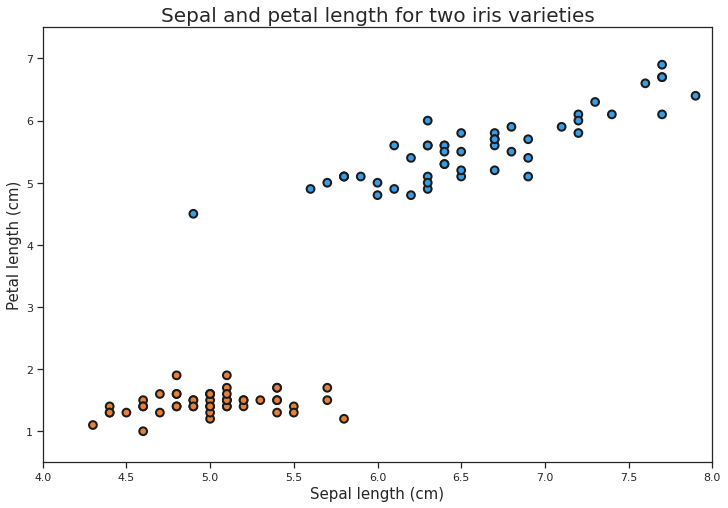

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(X1["sepal length (cm)"], X1["petal length (cm)"], c= y1, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.xlim(4,8)
plt.ylim(0.5,7.5)
plt.title("Sepal and petal length for two iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

We can see that, for these two varieties with these features, the groups are linearly seperable. Basically, we could draw a staight line on these axes and all of the points reprensenting each class would be on different sides of the line.

### What would we do?



The question is, which line should we draw?

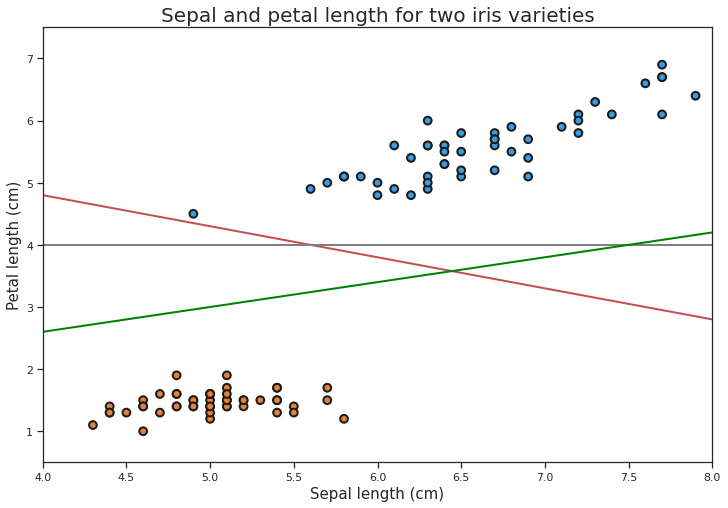

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

xmin=4
xmax=9

#Plot the lines
plot_line(xmin, xmax, 4.8, -0.5, "r")
plot_line(xmin, xmax, 4, 0, "grey")
plot_line(xmin, xmax, 2.6, 0.4, "green")

plt.scatter(X1["sepal length (cm)"], X1["petal length (cm)"], c= y1, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.xlim(4,8)
plt.ylim(0.5,7.5)
plt.title("Sepal and petal length for two iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### What's the best line?

The three lines shown above all linearly separate the classes. When deciding which line is 'best' we need to think about what it's going to be used for. With machine learning we almost always want to construct a model on training data and then generalise this model to new data we haven't seen before. In this case we are training the model on data which is labeled, but we might want to create an algorithm which could label new data just based on petal and sepal length. We should try and make this classification as robust to variations as possible.

One way to think about robustness is how far the line is from getting a data point wrong. The larger this distance, the more generalisable the line. We can plot this below:

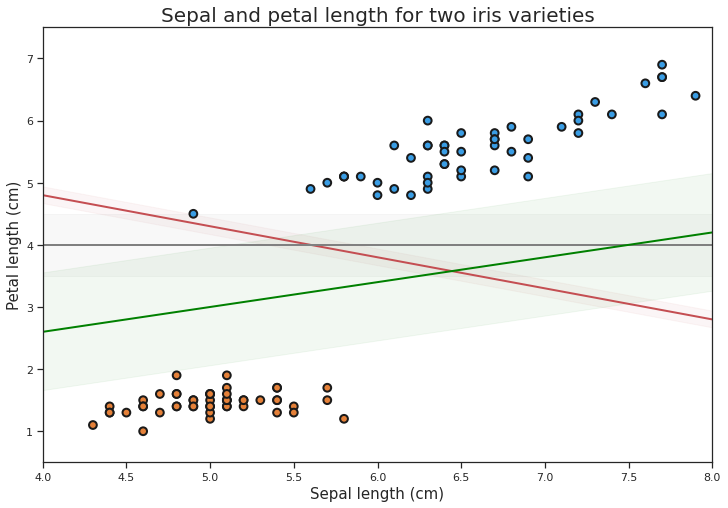

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))

xmin=4
xmax=9
xfit = np.linspace(-xmin, xmax)

#Draw the lines and the border around them using a loop
for yval, g, col in [(4.8, -0.5, "r"), (4,0, "grey"), (2.6,0.4, "green")]:
  plot_line(xmin, xmax, yval, g, col)
  min_dist=np.inf
  for xcord, ycord in zip(X1["sepal length (cm)"],X1["petal length (cm)"]):
    dist=shortest_distance(xcord, ycord, xmin, yval, g)
    if dist<min_dist:
      min_dist=dist
  yfit = g * xfit + yval-g*xmin
  plt.fill_between(xfit, yfit - min_dist, yfit + min_dist, edgecolor='none',
                     color=col, alpha=0.05)


plt.scatter(X1["sepal length (cm)"], X1["petal length (cm)"], c= y1, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.xlim(4,8)
plt.ylim(0.5,7.5)
plt.title("Sepal and petal length for two iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

Of these lines, the green one does the 'best' job under our criteria. What we need is a method to find the 'best' possible line, i.e. one with the maximum margin. Fortunately, such a method exists and it's called **Support Vector Machines (SVM)**

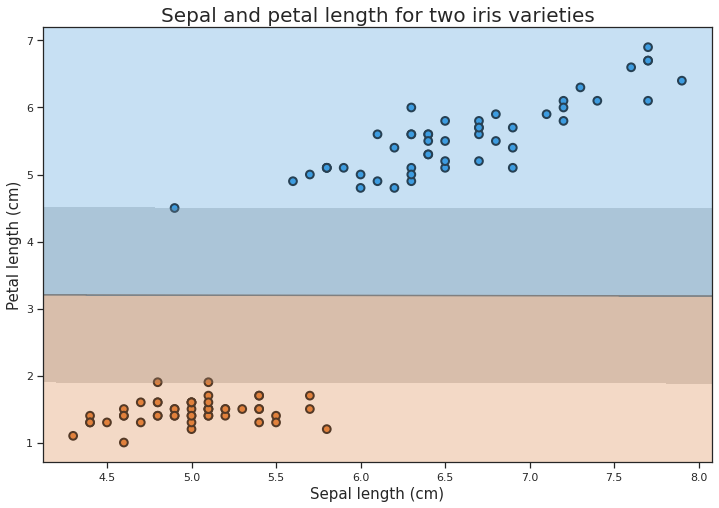

In [ ]:
#First we create model object and specify hyperparameters
svm_model1= SVC(kernel="linear")

#Then we can fit it to our data
svm_model1.fit(X1, y1)

#Let's plot the result
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(X1["sepal length (cm)"], X1["petal length (cm)"], c= y1, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plot_svc_decision_function(svm_model1, ax, plot_support=False)
plt.title("Sepal and petal length for two iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

As you can see, we've identified the line with the largest symmetric region either side. The boundary of this line is defined by the points it is touching on either side.

### Trying a harder problem (two similar varieties)

This was quite an easy classification problem. What if we present SVM with data which is not linearly seperable (perfectly divded by a straight line)?

**Here I am going to change which iris varieties we are looking at, I'm choosing two which are closer together.**

In [ ]:
# Create a new 2 class dataset with the second iris variety
df2=iris.copy()

# Drop one of the iris varieties
df2 = df2.drop(df2[df2["target"]==0].index)

# Recode the targets, for easier processing later

df2[df2==1] =  0
df2[df2==2] =  1

# Drop two of the features so that we can work in 2-D space easily
df2 = df2.drop(["sepal width (cm)", "petal width (cm)"], axis=1)

X2= df2[["sepal length (cm)", "petal length (cm)"]]
y2= df2["target"]

### Plotting our data

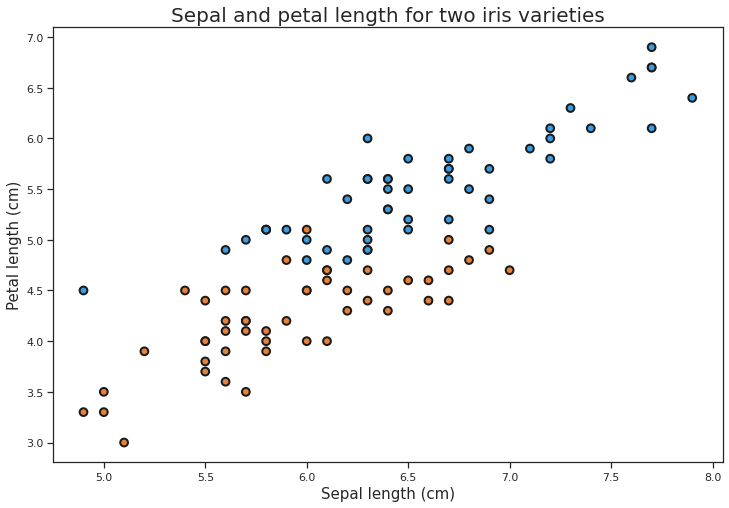

In [ ]:
#Let's plot our data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(X2["sepal length (cm)"], X2["petal length (cm)"], c= y2, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.title("Sepal and petal length for two iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

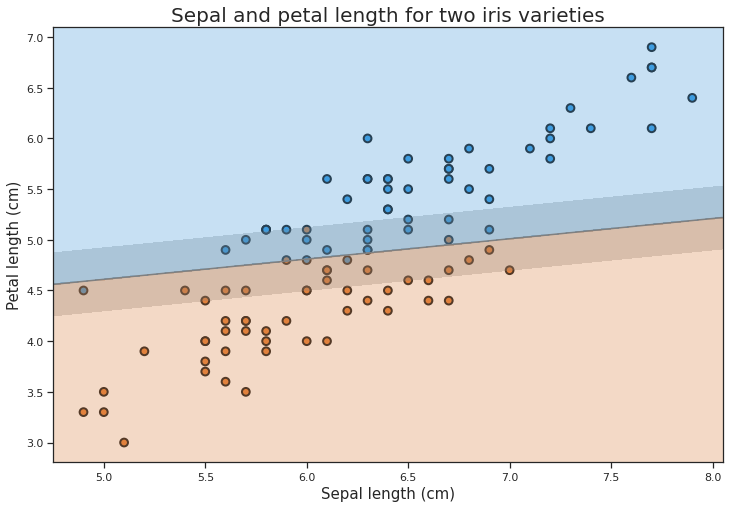

In [ ]:
#First we create model object and specify hyperparameters
svm_model2= SVC(kernel="linear")

#Then we can fit it to our data
svm_model2.fit(X2, y2)

#Let's plot the result
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(X2["sepal length (cm)"], X2["petal length (cm)"], c= y2, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plot_svc_decision_function(svm_model2, ax, plot_support=False)
plt.title("Sepal and petal length for two iris varieties", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### Tuning a hyperparameter

This graph is a little trickier to interpret. We've still drawn the 'best' line we can, but this time the two classes are not linearly separable. In this case the algorithm is trying to make a tradeoff when it decides what 'best' is. We could define 'best' two different ways:

* The line which misclassifies the smallest number of points
* The line which has the largest boundary given some allowable number of misclassifcations

Too much preference for the former increases the influence of outliers, too much preference for the latter leads to lots of misclassification. An algorithm that generalises will balance both. For SVM this parameter is called *C* and we specify it in the model. 

Below is a graph that shows the difference between high and low C. **Low C values prioritize generalizability. High C values prioritize in-sample accuracy.**

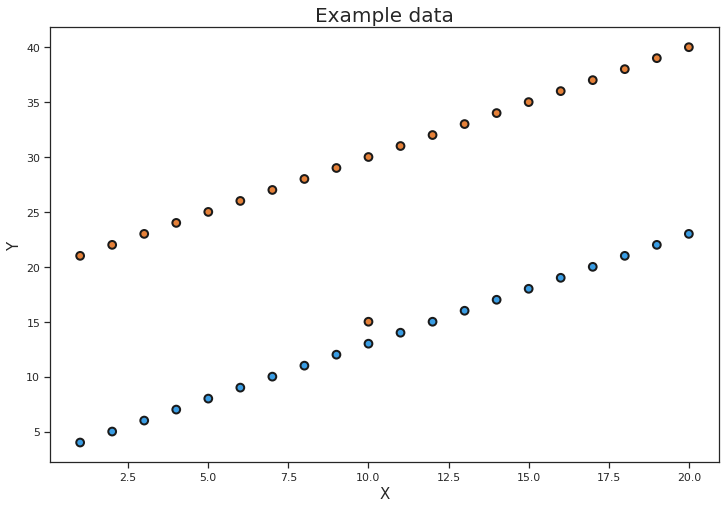

In [ ]:
#Set up straight line data

x1_straight = np.append(np.arange(1, 21), np.arange(1, 21))
x1_straight = np.append(x1_straight, 10).reshape(-1, 1)
x2_straight = np.append((np.arange(1, 21) + 20), (np.arange(1, 21) + 3))
x2_straight = np.append(x2_straight, 15).reshape(-1, 1)
x_straight = np.concatenate((x1_straight, x2_straight), axis = 1)

y_straight = np.append(np.zeros(20), np.ones(20))
y_straight = np.append(y_straight, 0).astype('int')

#Plot high C results
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(x_straight[:,0], x_straight[:, 1], c= y_straight, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.title("Example data", fontsize=20)
plt.ylabel("Y", fontsize=15)
plt.xlabel("X", fontsize=15)
plt.show()

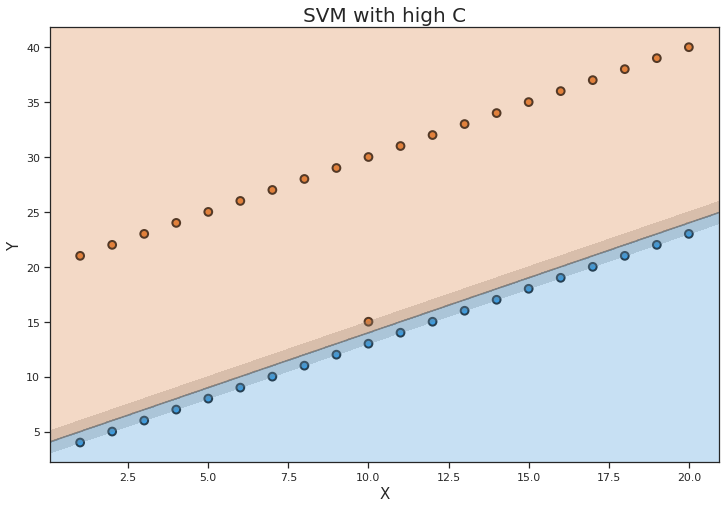

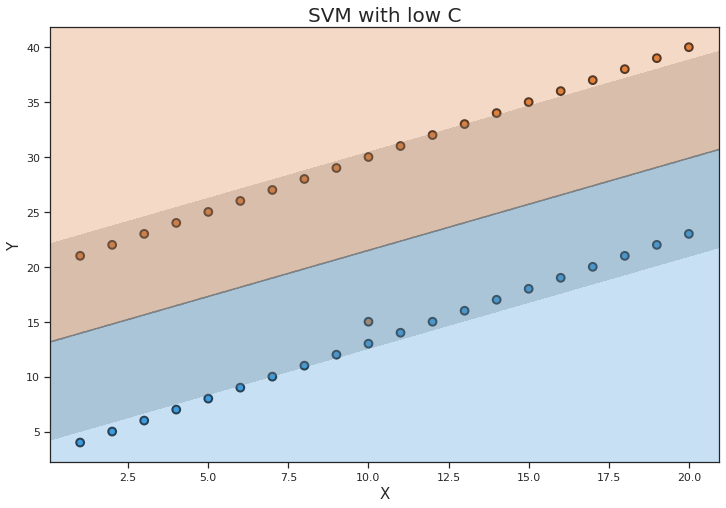

In [ ]:


#Create SVM models with high C and low C
svm_model_straight_high= SVC(kernel="linear", C=1)
svm_model_straight_low= SVC(kernel="linear", C=0.001)

#Then we can fit it to our data
svm_model_straight_high.fit(x_straight, y_straight)
svm_model_straight_low.fit(x_straight, y_straight)

#Plot high C results
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(x_straight[:,0], x_straight[:, 1], c= y_straight, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plot_svc_decision_function(svm_model_straight_high, ax, plot_support=False)
plt.title("SVM with high C", fontsize=20)
plt.ylabel("Y", fontsize=15)
plt.xlabel("X", fontsize=15)
plt.show()

#Plot low C results
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(x_straight[:,0], x_straight[:, 1], c= y_straight, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plot_svc_decision_function(svm_model_straight_low, ax, plot_support=False)
plt.title("SVM with low C", fontsize=20)
plt.ylabel("Y", fontsize=15)
plt.xlabel("X", fontsize=15)
plt.show()

Now we can do the same thing with our iris data. Below shows a high value of C (fewest points wrong).

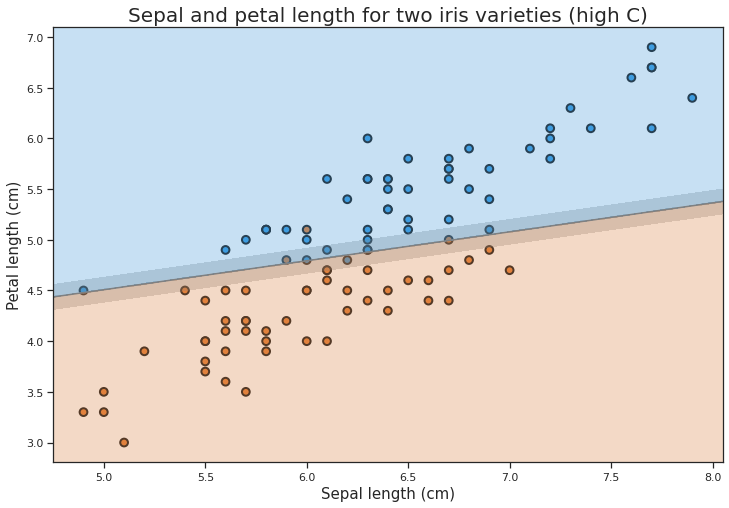

In [ ]:
#First we create model object and specify hyperparameters
svm_model4= SVC(kernel="linear", C=100)

#Then we can fit it to our data
svm_model4.fit(X2, y2)

#Let's plot the result
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(X2["sepal length (cm)"], X2["petal length (cm)"], c= y2, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plot_svc_decision_function(svm_model4, plot_support=False)
plt.title("Sepal and petal length for two iris varieties (high C)", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

This low C model is trying to find the largest margin


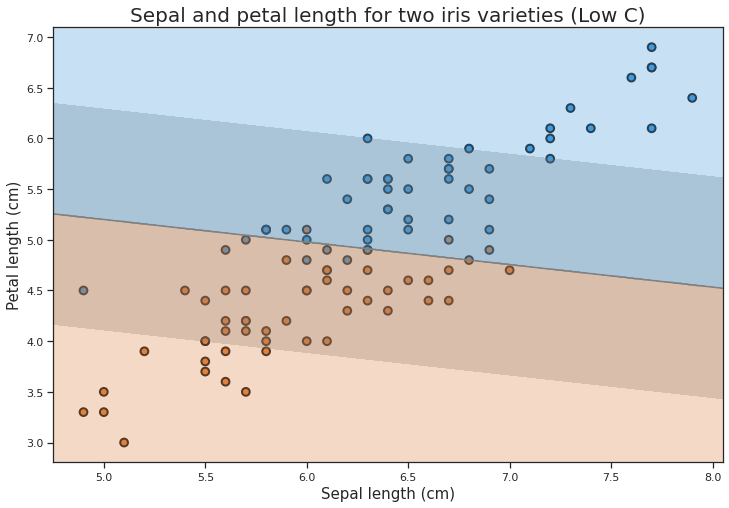

In [ ]:
#First we create model object and specify hyperparameters
svm_model3= SVC(kernel="linear", C=0.03)

#Then we can fit it to our data
svm_model3.fit(X2, y2)

#Let's plot the result
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.scatter(X2["sepal length (cm)"], X2["petal length (cm)"], c= y2, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plot_svc_decision_function(svm_model3, ax, plot_support=False)
plt.title("Sepal and petal length for two iris varieties (Low C)", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### Judging our model

We can see how well this model fits the training data by looking at a confusion matrix, which displays the number of:
* True Negatives (correct 0 classifications)
* True Positives (correct 1 classifications)
* False Negatives (incorrect 0 classifications)
* False positives (incorrect 1 classifications)

Having a single-number evaluation metric is useful for comparing the performance of different models. We often use accuracy the propoortion of points which are correctly classified. 

* Accuracy = $\frac{TP + TN}{TP + TN + FP + FN}$

However, accuracy can sometimes be misleading, imagine if you had a dataset in which you were trying to predict deaths, but only 1% of the people in your dataset died, an algorithm could obtain a 99% accuracy by always predicting survival.

In cases where classes are imbalanced, Sensitivity (also called recall or true positive rate) is a useful measure that indicates the percentage of class  1 who are correctly identified. In the context of many health problems, having a high sensitivity is very important, since it tells us the algorithm is able to correctly identify the most critical cases. However, optimizing for sensitivity alone may lead to the presence of many false alarms (false positives). Therefore, it is important to also have in mind specificity, which tells us the the percentage of class 0 who are correctly identified as such.

* Sensitivity = $\frac{TP}{TP + FN}$
* Specificity = $\frac{TN}{TN + FP}$

One way of combining sensitivity and specificity in one measure is using the area under the receiver–operator characteristics (ROC) curve (AUC), which is a graphical plot that illustrates the performance of a binary classifier as its discrimination threshold is varied. We will go over the ROC plot later on.

For this problem we have perfectly balanced classes, so we will caluclate sensitivity and specificifty, but accuracy is a fine metric to use.

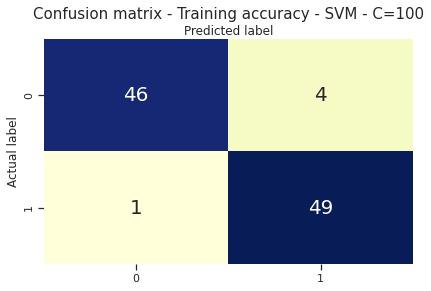

Accuracy is 95.0 %
Sensitivity is 98.0 %
Specificity is 92.0 %


In [ ]:
y_pred2=svm_model4.predict(X2)
confusion_heatmap(y2, y_pred2, "- Training accuracy - SVM - C=100")

However, monitoring accuracy on the training set is bad practice, because this over estimates the accuracy of our model. Of course we are good at predicting data that we have already seen! We should talk about how we partition data.

## Data partitioning

### Goal: Splitting our data so we can have a valid estimate for our model's accuracy in unseen data.

Data should be split into three different groups:

* **Training set** - The data that we use to train the model. 
* **Validation set** - The data that we use as a first check of the model performance, to tune algorithms and to select a final model to run on the test set
* **Test set** - The final test of our model, which gives the best indication of how the model will generalise to new data. It is *very* important that **only one model is evaluated on the test set, and the test set is kept entirely separate from the training and tuning process**. Any bleeding of information from the test set to the training or validation set will mean that the evaluation of the test set will be over optimistic. 

In cases where the data is highly imbalanced, it might be a good option to force an oversampling of the minority class, or a undersampling of the majority class so that the model is not biased towards the majority class. This should be performed on the training set, whereas the test set should maintain the class imbalance found on the original data, so that when evaluating the final model a true representation of data is used.

In this case, we have balanced data and we will only be using a training and validation set, so we won't know the true accuracy of our model on new data. This is partly because we are working with very small datasets so lots of partitions cost us too much training data. For any real problem you need all three sets. A typical split for training/validation/test is 50%/30%/20%.

Instead of using a validation set, you can perform k-fold cross validation, which effectively creates k mini validation sets and averages the results across them.

Let's try creating a validation set with our latest model

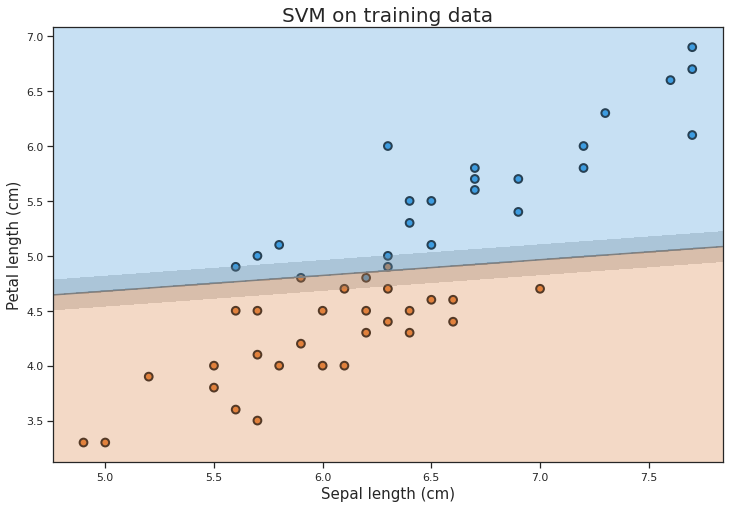

In [ ]:
#Randomly assign records to test or training
train_df2, val_df2=train_test_split(df2, test_size=0.5, random_state=1)

#Create X and y for training and validation
X_train2= train_df2[["sepal length (cm)", "petal length (cm)"]]
y_train2= train_df2["target"]
X_val2= val_df2[["sepal length (cm)", "petal length (cm)"]]
y_val2= val_df2["target"]

#Creat model object
svm_model5= SVC(kernel="linear", C=100)

#Fit to test data
svm_model5.fit(X_train2, y_train2)

#Let's plot the result
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax= plt.scatter(X_train2["sepal length (cm)"], X_train2["petal length (cm)"], c= y_train2, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)

plot_svc_decision_function(svm_model5, plot_support=False)
plt.title("SVM on training data", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

Now, let's see how well this same model generalises to our validation data, which the model hasn't seen.

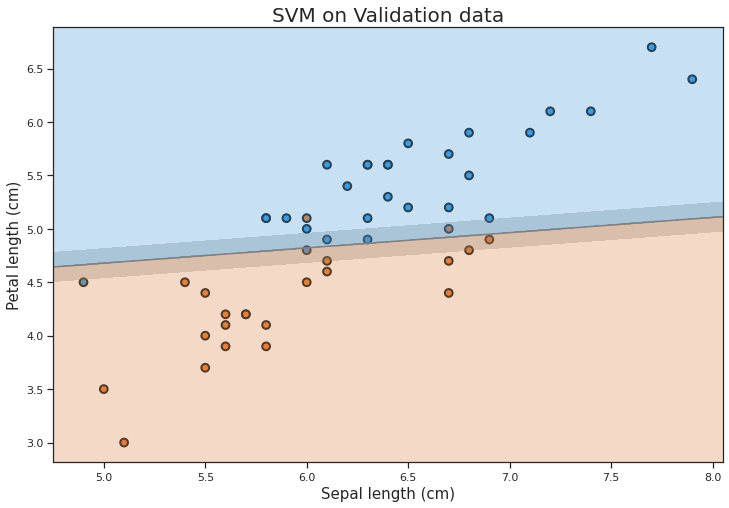

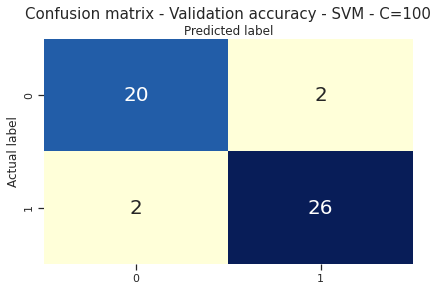

Accuracy is 92.0 %
Sensitivity is 92.86 %
Specificity is 90.91 %


In [ ]:
#Plot model with validation data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax= plt.scatter(X_val2["sepal length (cm)"], X_val2["petal length (cm)"], c= y_val2, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)

plot_svc_decision_function(svm_model5, plot_support=False)
plt.title("SVM on Validation data", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

y_pred3=svm_model5.predict(X_val2)
confusion_heatmap(y_val2, y_pred3, "- Validation accuracy - SVM - C=100")

### Choosing a hyperparameter

We can see that if the model was fit to this data, it could have drawn a line which better separated the two classes, this tells use how well our model generalises. The vast majority of the points are still correctly classified.

The purpose of validation data is to tune hyperparameters (in this case the value of C) and compare across methods. Once the best model is chosen this can then be deployed on unseen training data to best assess the performance on unseen data. Let's see how different levels of C perform.

For C= 0.001 , accuracy is  0.44
For C= 0.01 , accuracy is  0.46
For C= 0.1 , accuracy is  0.82
For C= 1 , accuracy is  0.88
For C= 10 , accuracy is  0.92
For C= 100 , accuracy is  0.92
For C= 1000 , accuracy is  0.88


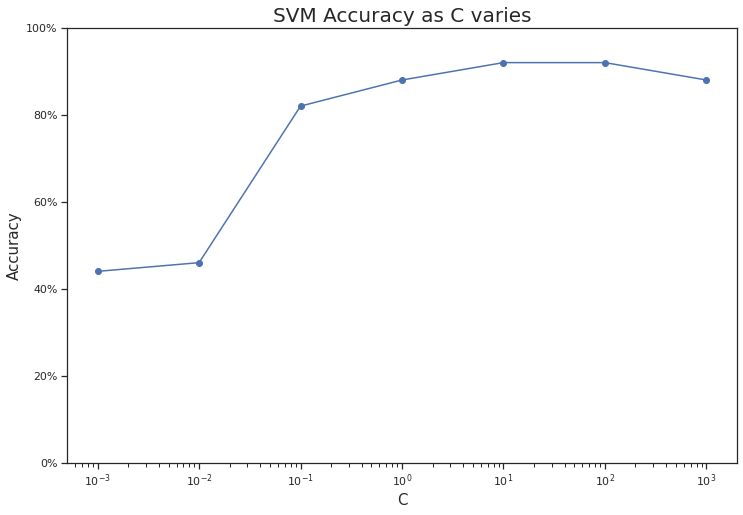

In [ ]:
C_val_list=[0.001, 0.01, 0.1, 1, 10, 100, 1000]
C_accuracy=[]
for C in C_val_list: 
  SVM_model_temp=SVC(kernel="linear", C=C)
  SVM_model_temp = SVM_model_temp.fit(X_train2,y_train2)
  y_pred_temp=SVM_model_temp.predict(X_val2)
  accuracy=metrics.accuracy_score(y_val2, y_pred_temp)
  C_accuracy.append(accuracy)
  print("For C=", C, ", accuracy is ", accuracy)
  

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.plot(C_val_list, C_accuracy, marker='o')
plt.title("SVM Accuracy as C varies", fontsize=20)
plt.ylim(0,1)
ax.set_xscale('log')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.ylabel("Accuracy", fontsize=15)
plt.xlabel("C", fontsize=15)
plt.show()

In this case, we might choose C=10 as it gives us the best accuracy. This is the value of C we would use in the test set.

This should be enough to give you a basic understanding of how SVM is used in practice, next lets look at a slightly more flexible algorithm.

## Supervised Learning - Decision Trees

### Question: I found a new flower, what type is it?

### Goal: Classify our data. We are still trying to find a decision rule, but with a more flexible algorithm. Optimise hyperparameters using a validation set.



Decision trees split data using multiple binary splits to contiuously divide the data into smaller groups. In 2 dimensions you can think of this as drawing a series of horizontal or vertical lines on the scatter plot to define decision boundaries. Decision trees are very useful when you're not sure what features you should use and you don't have a good model of the data, because they don't make many assumptions about the form of the mapping function.

We're going to use a decision tree with a CART algorithm, which greedily looks for the best split to make. Think of this as choosing the split at every time step which does the best job of dividing the data in two.

First, let's look at a one layer decsion tree (sometimes referred to as a stump). 

We'll use the same dataset as before, but we'll make sure to **partition our data before we begin any training** (remember, you should always do this for supervised learning problems)

### Setting up data and partitioning

In [ ]:
#Randomly assign records to test or training
train_df2, val_df2=train_test_split(df2, test_size=0.5, random_state=2)

#Create X and y for training and validation
X_train3= train_df2[["sepal length (cm)", "petal length (cm)"]]
y_train3= train_df2["target"]
X_val3= val_df2[["sepal length (cm)", "petal length (cm)"]]
y_val3= val_df2["target"]

### Creating a decision stump

In [ ]:
DT_model1 = tree.DecisionTreeClassifier(max_depth=1)
DT_model1 = DT_model1.fit(X_train3,y_train3)

An advantage of simple decision trees is that they are very intepretable. It is easy to plot the 'graph' and see how the tree classifies the points.

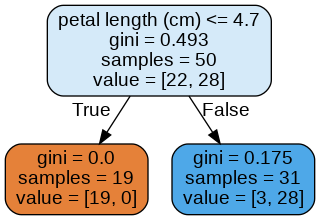

In [ ]:
graph = create_graph(DT_model1)
Image(graph.create_png())

Here we can see one simple rule for classifying points. Any flower with a petal length below 4.75 is an orange, otherwise it is a blue. Even with only a simple rule, in this data set we have a training accuracy of 94%. We know the accuracy because we can see that in the left hand box there are 19 organges and 0 blues. In the right hand box there are 3 oranges and 28 blues. Therefore we have an accuracy of:

$Accuracy = \frac{TP + TN}{TP + TN + FP + FN} = \frac{19 + 28}{19 + 28 + 0 + 3} = 0.94$

For more complex trees you should use a confusion matrix rather than counting individual values in the tree.

We can also visualise this tree on a graph. Notice how the greedy CART algorithm has found the horizontal or vertical line which does the best job of splitting the data.

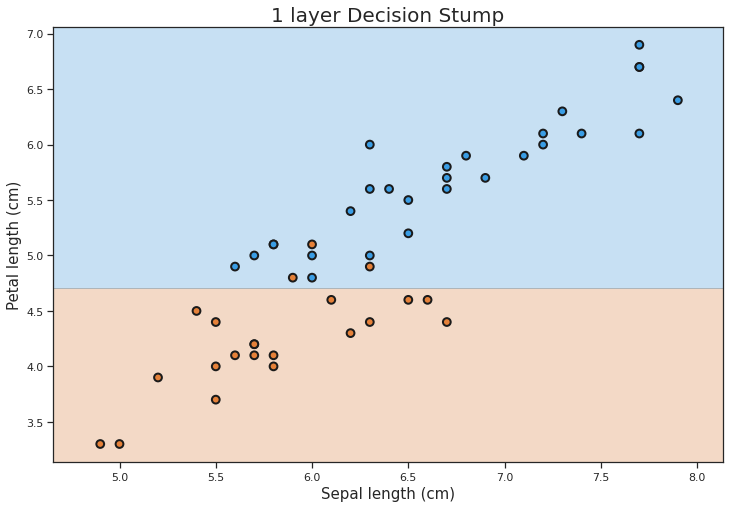

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model1, X_train3, y_train3, ax=ax)
plt.title("1 layer Decision Stump", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### Creating an unpruned tree

The opposite of a 'stump' is a decision tree with no limitation on the number of layers it can have. Without constraints decision trees can always perfectly fit the dataset because they can always create more rules to classify outliers. Here's what the looks like with our dataset.

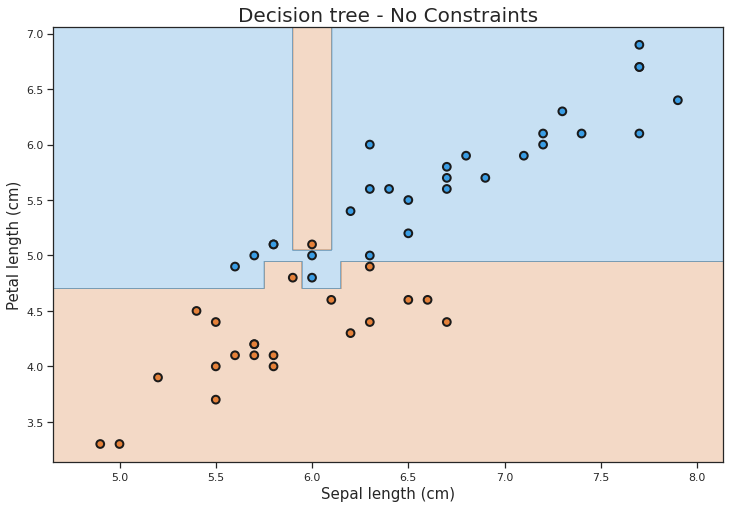

In [ ]:
#Create model object
DT_model2 = tree.DecisionTreeClassifier()

#Fit model to data
DT_model2 = DT_model2.fit(X_train3,y_train3)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model2, X_train3, y_train3, ax=ax)
plt.title("Decision tree - No Constraints", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
# plt.xlim(6.0, 6.5)
# plt.ylim(4.5, 5)
plt.show()

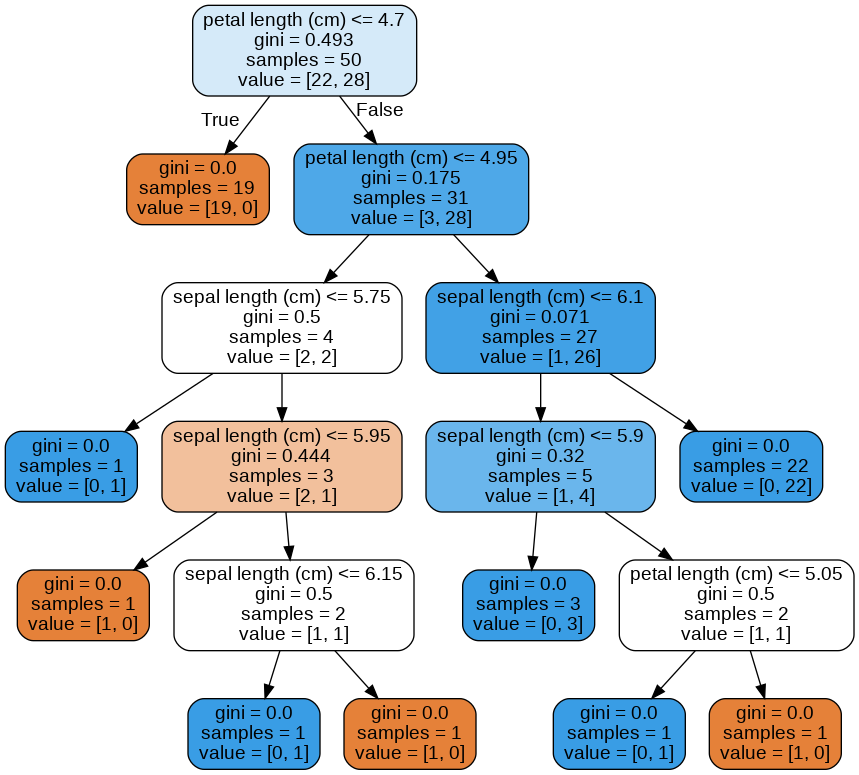

In [ ]:
# Plot graph
graph = create_graph(DT_model2)
Image(graph.create_png())

As you can see, when the decision tree is allowed to propegate, it can correctly classify all points in the training set. However, we want to build a generalisable model, not just a model that works well in the training set and it's very likely this decision tree would not generalise well because it is over fitted. Imagine if this was asked to classify the points (6, 6.5) and (6.5, 4.7), as shown below.


(The very astute may notice there is one unsplit node and one corresponding miscategorised point, this is because there are two points exactly on top of one another, so the algorithm cannot draw a line which correctly categorises both of them.)

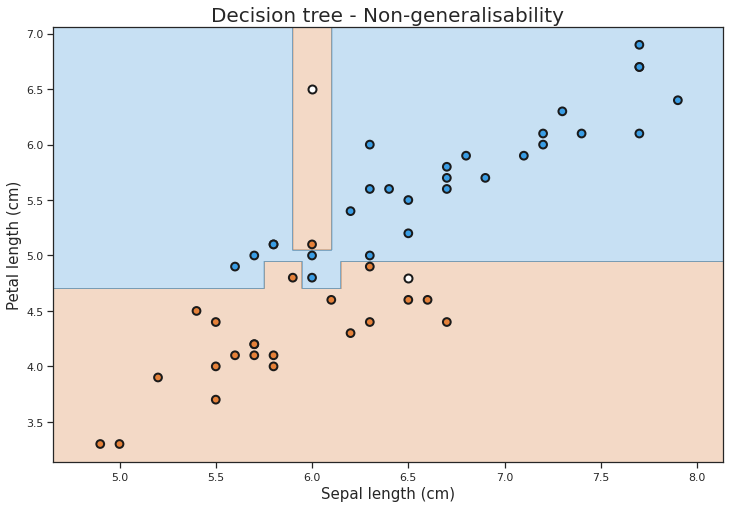

In [ ]:
#Plot the data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model2, X_train3, y_train3, ax=ax)
plt.plot([6], [6.5], marker='o', markersize=8, color="white", markeredgecolor='k', markeredgewidth=2)
plt.plot([6.5], [4.8], marker='o', markersize=8, color="white", markeredgecolor='k', markeredgewidth=2)
plt.title("Decision tree - Non-generalisability", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

Our model would classify (6, 6.5) as 'orange', but, based on the other data we can see, it would probably be 'blue'. Likewise (6.5, 4.7) would also be misclassified. The problem of overifitting would be even worse if we had more features (and therefore higher dimensionality), because the data would be sparser and there would be more empty space to draw poor conclusions.

### Overfitting - Decision Trees on Random Data

We can really demonstrate this overfitting by fitting a decision tree to random data

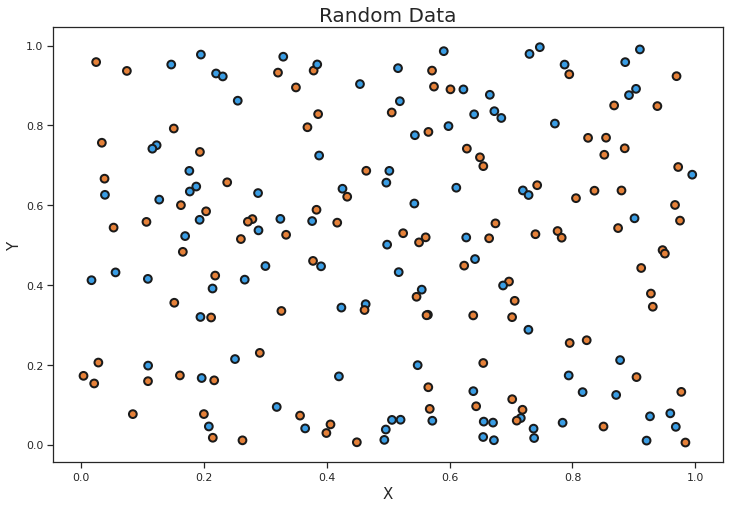

In [ ]:
X_random = pd.DataFrame(np.random.rand(200, 2))
y_random = np.random.randint(2, size=(200, 1))

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
ax= plt.scatter(X_random.iloc[:, 0], X_random.iloc[:, 1], c= y_random, edgecolor='k',
                linewidth=2, marker='o', s=60, cmap=cm)
plt.title("Random Data", fontsize=20)
plt.ylabel("Y", fontsize=15)
plt.xlabel("X", fontsize=15)
plt.show()

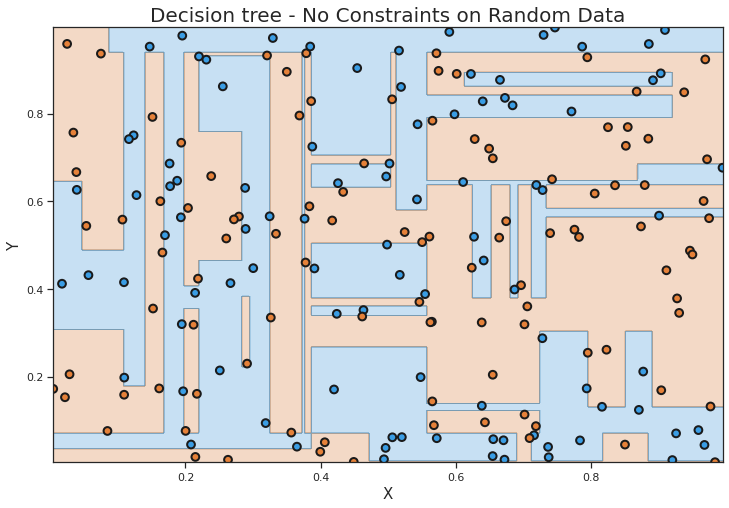

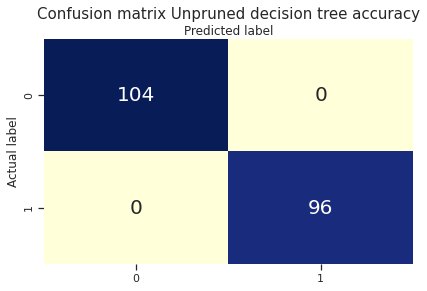

Accuracy is 100.0 %
Sensitivity is 100.0 %
Specificity is 100.0 %


In [ ]:
DT_model_rand = tree.DecisionTreeClassifier()

#Fit model to data
DT_model_rand = DT_model_rand.fit(X_random,y_random)

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model_rand, X_random, y_random, ax=ax)
plt.title("Decision tree - No Constraints on Random Data", fontsize=20)
plt.ylabel("Y", fontsize=15)
plt.xlabel("X", fontsize=15)
plt.show()

confusion_heatmap(y_random, DT_model_rand.predict(X_random), "Unpruned decision tree accuracy")

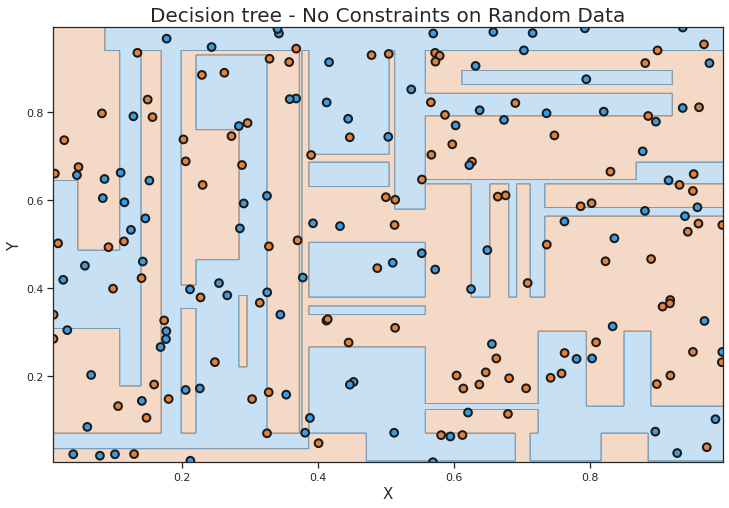

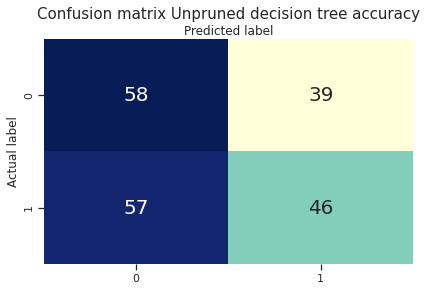

Accuracy is 52.0 %
Sensitivity is 44.66 %
Specificity is 59.79 %


In [ ]:
X_random2 = pd.DataFrame(np.random.rand(200, 2))
y_random2 = np.random.randint(2, size=(200, 1))

fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model_rand, X_random2, y_random, ax=ax)
plt.title("Decision tree - No Constraints on Random Data", fontsize=20)
plt.ylabel("Y", fontsize=15)
plt.xlabel("X", fontsize=15)
plt.show()

confusion_heatmap(y_random2, DT_model_rand.predict(X_random2), "Unpruned decision tree accuracy")

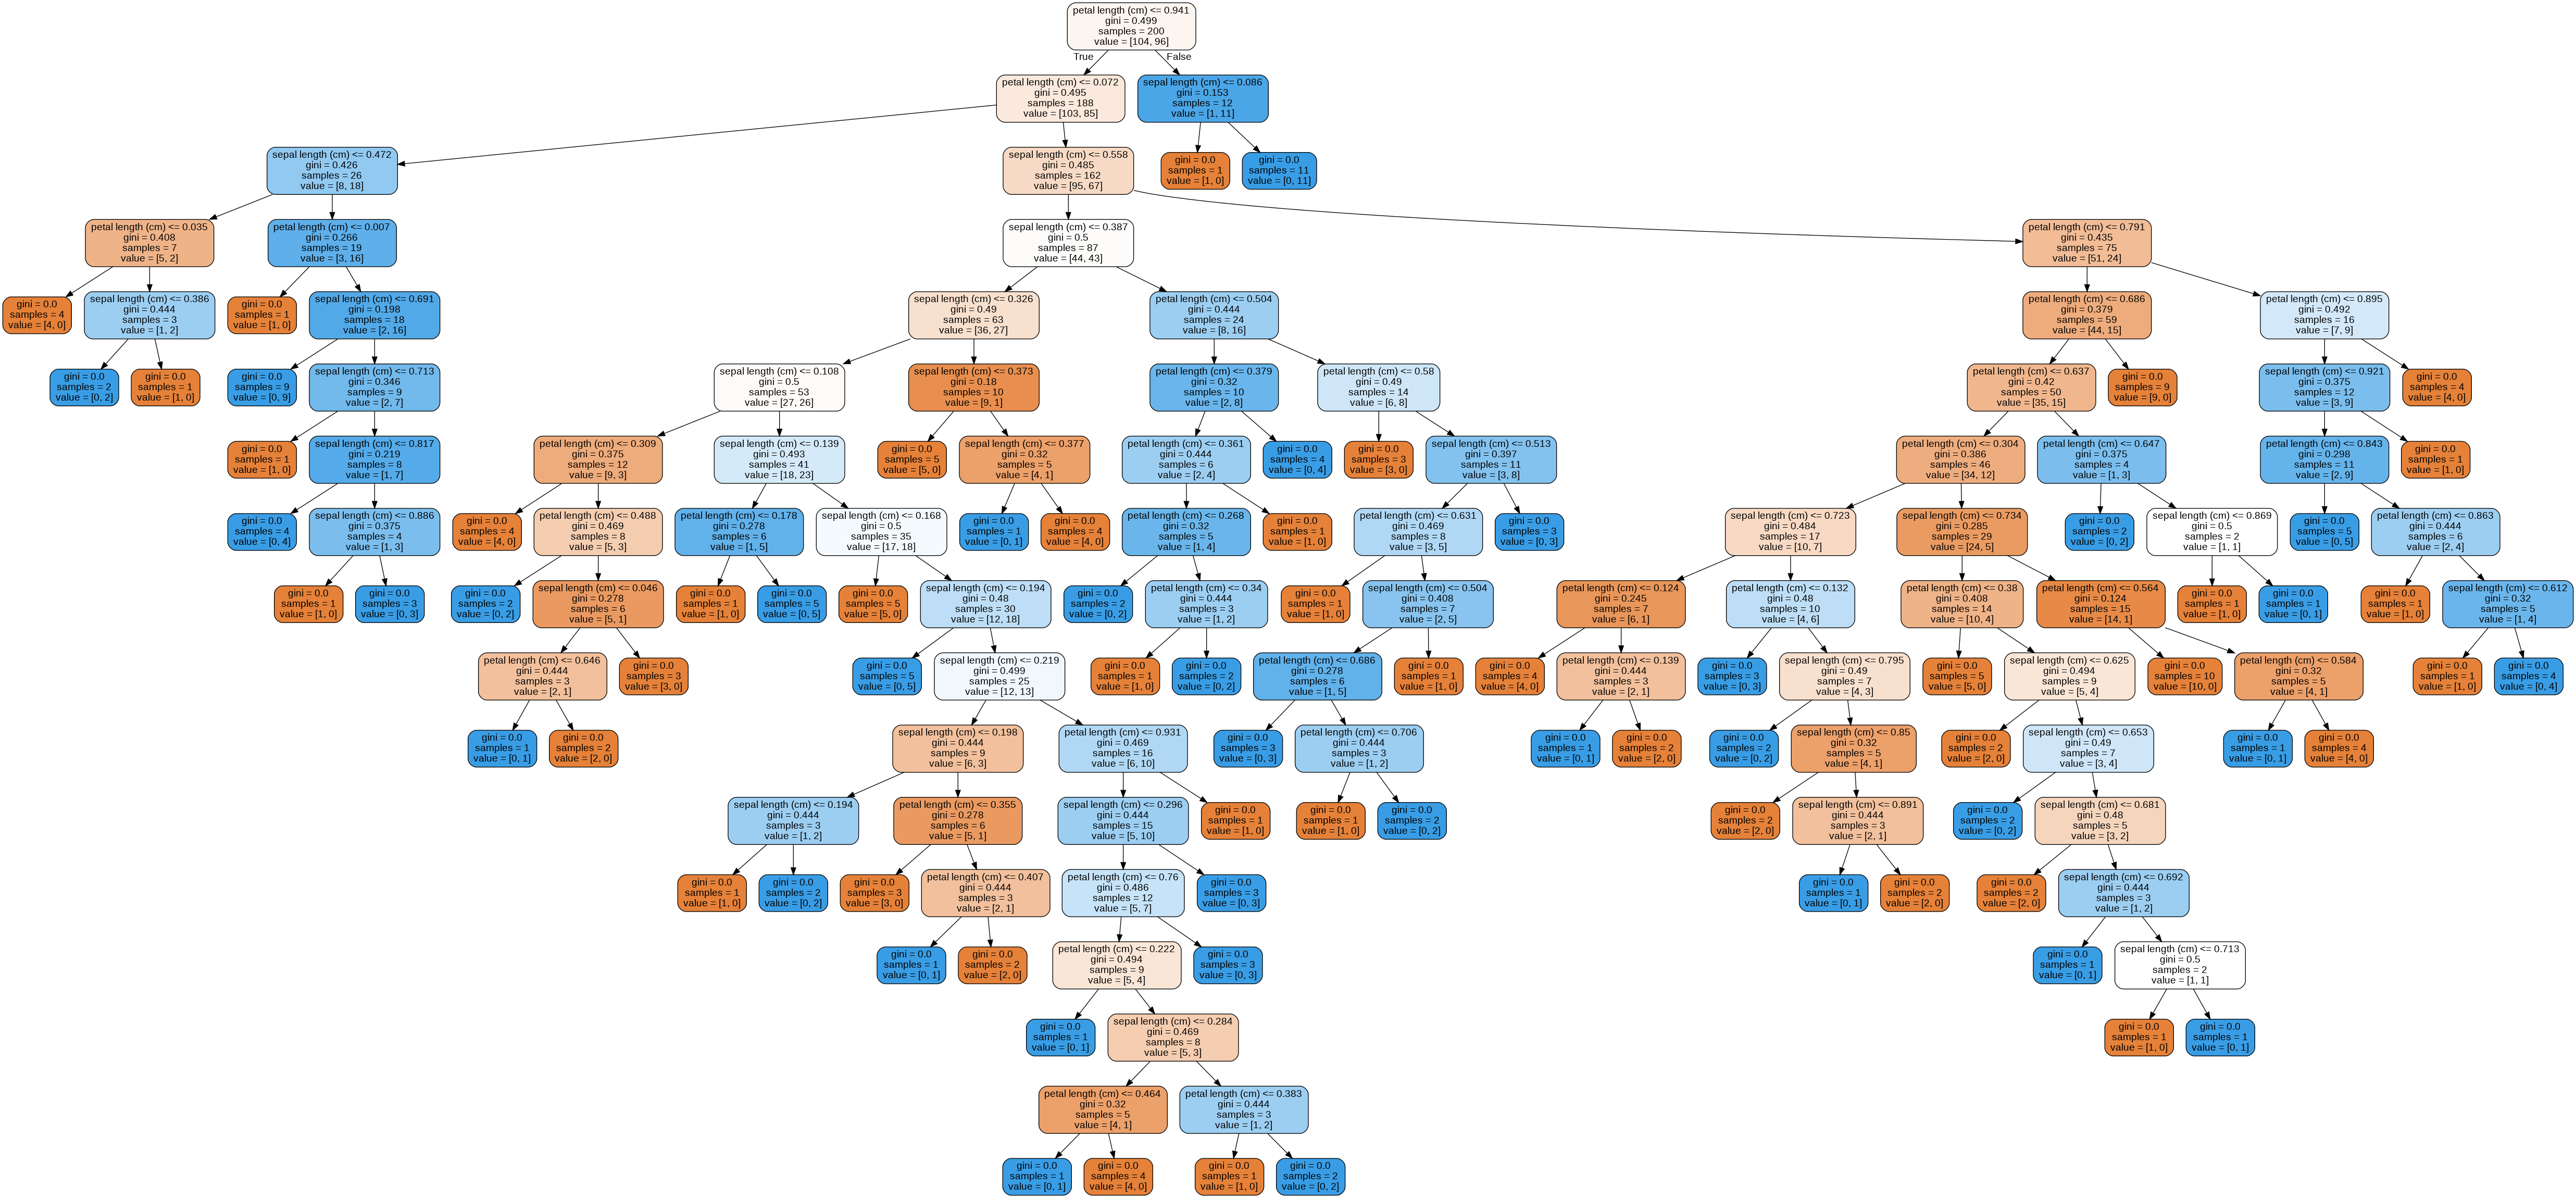

In [ ]:
graph = create_graph(DT_model_rand)
Image(graph.create_png())

### Pruning our tree

To make sure the model is not overfitting, we can 'prune' our tree by using stopping criteria. This means specifying some limits to how far the tree is allowed to extend so that we do not lose generalisability. In python's sklearn package some of the most useful parameters are:

* **criterion**: function which the CART algorithm is minimising when it makes a split. The default option is the Gini index, which is 0 when a leaf node is 'pure' (contains only one class) and 0.5 when evenly split between two classes. The algorithm weights the Gini from each node by how many instances are in that node and attempts to minimise the total in a greedy manner

* **splitter**: strategy used to choose the split at each node. Supported strategies are “best” to choose the best split and “random” to choose the best random split.

* **max_depth**: maximum depth of the tree.
If None, nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

* **min_samples_split**: minimum number of samples required to split an internal node.

* **min_samples_leaf**: minimum number of samples required to be at a leaf node. 

* **min_impurity_decrease**: minimum decrease in the impurity measure (e.g. Gini index) a split must create before it is allowed

* **max_leaf_nodes**: grow a tree with max_leaf_nodes in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.

* **random_state**: seed used by the random number generator, useful if you want to keep the same output across multiple runs (some options make decision trees stochastic) 

If you're curious about the parameters of a function, then you should always look at the documents (google is your friend here). The docs for the decision tree function were are using are here:

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


Let's create a new model and tree using some of these parameters


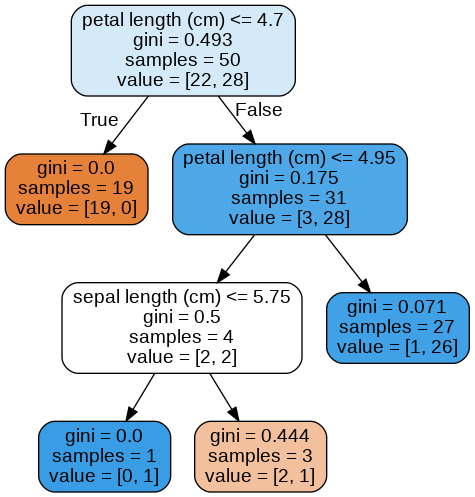

In [ ]:
#Create model object
DT_model3 = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=3, min_impurity_decrease=0.008, random_state=1)

#Fit to train data
DT_model3 = DT_model3.fit(X_train3,y_train3)

#Plot Graph
graph = create_graph(DT_model3)
Image(graph.create_png())

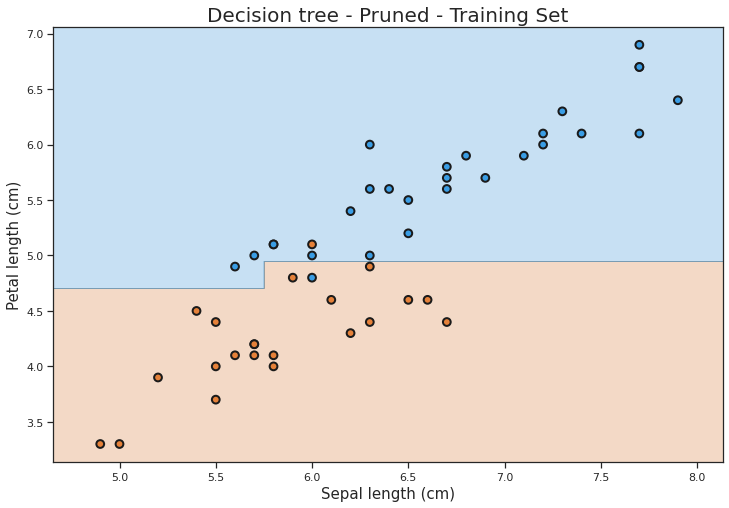

In [ ]:
#Plot the data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model3, X_train3, y_train3, ax=ax)
plt.title("Decision tree - Pruned - Training Set", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

### Interpreting our tree

This looks better! Our model is very simple, only having 3 rules, which means it is likely to generalise well, but it correctly cateogorises most points. Not only this, but because it's so simple it's very interpretable. We could tell a botanist in the field to follow these rules for the categorisation of different flowers:

* If the petal length is less than 4.7cm it's likely to be 'orange'.
* If the petal length is more than 4.95cm it's likely to be a 'blue'
* For those in between, if the sepal length is longer than 5.75 it's likely to be orange, otherwise blue.

One of the biggest advantages of decision trees is that they can be interpretted like this.



### Checking accuracy on the validation data

To see whether our model is generalisable, let's divide check the performance on the validation data, the plot below shows the validation data plotted on the same model.

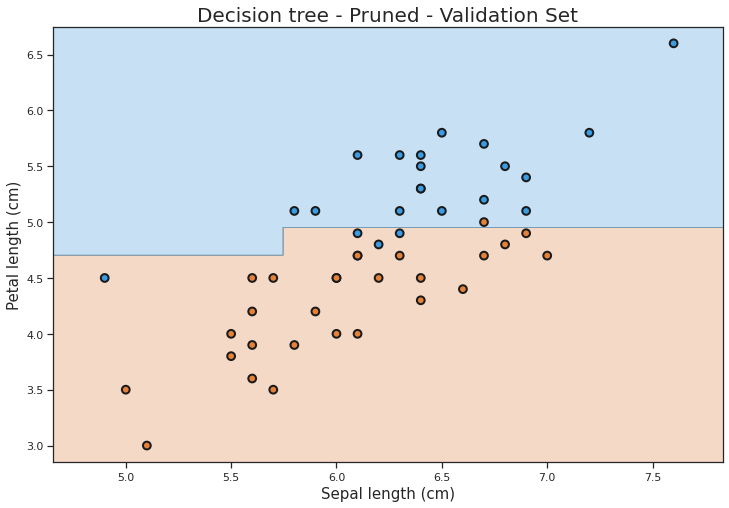

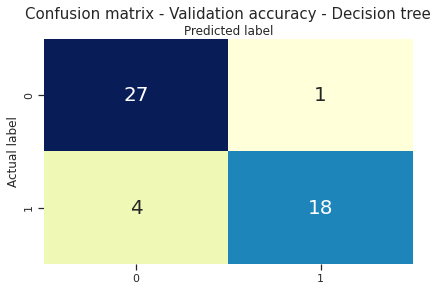

Accuracy is 90.0 %
Sensitivity is 81.82 %
Specificity is 96.43 %


In [ ]:
#Plot the data
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plot_tree_pred_2d(DT_model3, X_val3, y_val3, ax=ax)
plt.title("Decision tree - Pruned - Validation Set", fontsize=20)
plt.ylabel("Petal length (cm)", fontsize=15)
plt.xlabel("Sepal length (cm)", fontsize=15)
plt.show()

y_pred4=DT_model3.predict(X_val3)
confusion_heatmap(y_val3, y_pred4, "- Validation accuracy - Decision tree")

It's not the most accurate model. but there are only 50 datapoints in the training set, performance would likely improve if the model had more data to learn from. We can use the validation set to tune hyperparameters, shown below for one hyper parameter.

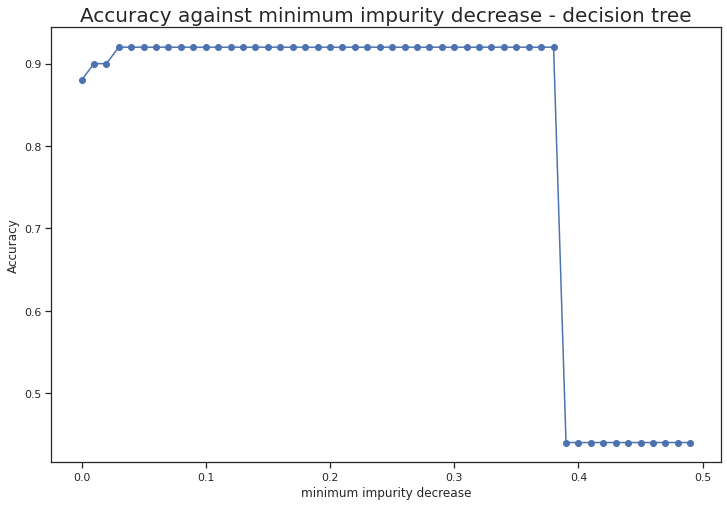

In [ ]:
acc_scores=[]
imp_decreases = np.arange(0, 0.5, 0.01)

for imp_decrease in imp_decreases: 
  DT_model_temp=tree.DecisionTreeClassifier(min_impurity_decrease=imp_decrease)
  DT_model_temp = DT_model_temp.fit(X_train3,y_train3)
  y_pred_temp=DT_model_temp.predict(X_val3)
  accuracy=metrics.accuracy_score(y_val3, y_pred_temp)
  acc_scores.append(accuracy)
  #print("For minimum impurity decrease", round(imp_decrease,2), ", accuracy is ", accuracy)
  
  
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.plot(imp_decreases, acc_scores, marker='o')
plt.title("Accuracy against minimum impurity decrease - decision tree", fontsize=20)
plt.ylabel("Accuracy")
plt.xlabel("minimum impurity decrease")
plt.show()




We can see that for small values of minimum impurity decrease the accuracy is lower because of over fitting, and for large values it is lower because the model is underfitted. So, for our test we could choose a minimum impurity decrease of ~0.2, since this has the highest accuracy in the validation set.

## Supervised learning - Random Forests

### Question: Based on a scan, is a cancer tumor malignant or benign?

### Goal: Classify data in a more complex dataset. Use a test set to estimate our model's performance in unseen data.



### What is a random forest?

Random forests use lots of decision trees to build a model which is better a predicting that any individual tree. They are a type of ensemble method - which just means a model which is a composite of other models. We can think of ensembles a bit like the 'wisdom of the crowds'. Imagine you are at a county fair and you want to estimate the weight of a cow. Lacking the apporpriate scales you could go and find yourself a cow expert and ask their opinion (the equivalent of building a single model). Or you could ask everyone at the fair and average their guesses, which might even out to be more accurate than the expert (an ensemble method).

A random forest involves building many decision trees, each of which is only shown a random subset of the features in the model and a random set of datapoints. Each decision tree can be used to probabilistically classify points and these probabilities can be aggregated into a single overall prediction. Typically only a very small number of features (often the square root of the total number of features) is shown to each tree in the forest. This helps to avoid overfitting and means that the algorithm is still reasonably fast to run. 

Random forests are particularly useful when there are many features and it's  robust to being given some features which aren't very predictive. The downside to random forests is that because there are so many trees the interpretability is lost. 

The dataset we've used thus far is too simple to use a random forest on effectively, but I'll show you some example code so that you can use them at a later date.

<img src='https://i1.wp.com/sefiks.com/wp-content/uploads/2017/11/random-forest.png?resize=602%2C344&ssl=1'>

### Reading in and cleaning a breast cancer dataset

In [ ]:
# load the dataset (this is already present in a package, which is why you don't need to download anything)
cancer_dataset = datasets.load_breast_cancer()
# Print out the dataset description which is shown below
print(cancer_dataset['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, f

In [ ]:
# Turn the dataset objects into a nice dataframe
df_c = pd.DataFrame(data=cancer_dataset['data'])
df_c.columns=cancer_dataset['feature_names']
df_c['target']=cancer_dataset['target']

This cancer dataset contains 30 features for 569 records. This is a binary classification problem - we want to predict whether the breast cancers are benign or malignant. 

In [ ]:
df_c

mean radius  mean texture  ...  worst fractal dimension  target
0          17.99         10.38  ...                  0.11890       0
1          20.57         17.77  ...                  0.08902       0
2          19.69         21.25  ...                  0.08758       0
3          11.42         20.38  ...                  0.17300       0
4          20.29         14.34  ...                  0.07678       0
..           ...           ...  ...                      ...     ...
564        21.56         22.39  ...                  0.07115       0
565        20.13         28.25  ...                  0.06637       0
566        16.60         28.08  ...                  0.07820       0
567        20.60         29.33  ...                  0.12400       0
568         7.76         24.54  ...                  0.07039       1

[569 rows x 31 columns]

### Random forest parameters

Let's fit a random forest to training data (50%) and test it on validation data (30%). We can then tune hyperparameters and check the final performance on the test data (20%). The default parameters for the algorithm can be found here:

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Note that the default number of features considered in each tree is:

```
sqrt(n_features)
```

So each tree will use 5 features (out of the 30). We specify that 100 trees should be created. Bootstrapping is True by default, so records will be sampled with (replacement) up to the original number.



### Running the random forest

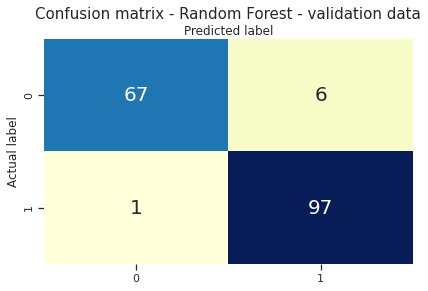

Accuracy is 95.91 %
Sensitivity is 98.98 %
Specificity is 91.78 %


In [ ]:
# split the dataset into training (50%), validation (30%) and test (20%)
train_c, val_c=train_test_split(df_c, test_size=0.5)
val_c, test_c=train_test_split(val_c, test_size=0.4)

X_train_c= train_c.drop(["target"], axis=1)
y_train_c= train_c["target"]
X_val_c= val_c.drop(["target"], axis=1)
y_val_c= val_c["target"]
X_test_c= test_c.drop(["target"], axis=1)
y_test_c= test_c["target"]

#Create model object
RF_model = ensemble.RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.001)

#Fit to train data
RF_model = RF_model.fit(X_train_c,y_train_c)

#Check the confusion matrix
y_pred_c=RF_model.predict(X_val_c)
confusion_heatmap(y_val_c, y_pred_c, "- Random Forest - validation data")


###Tuning the maximum depth

Let's tune the max depth on the accuracy of our model:

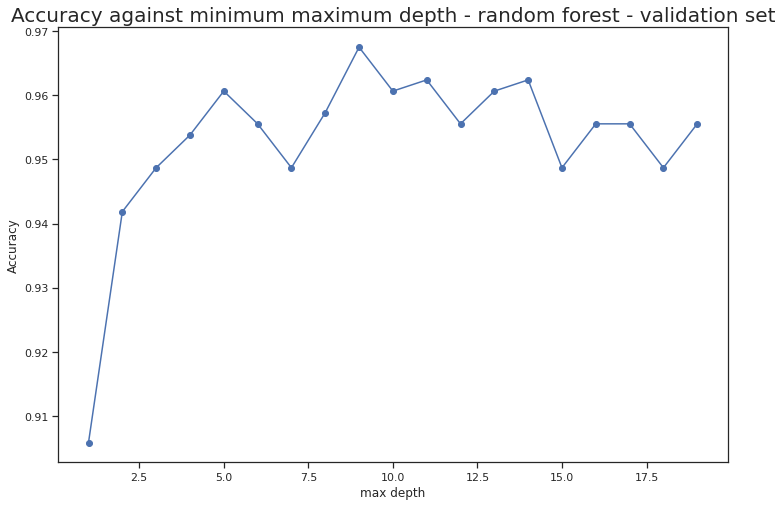

In [ ]:
roc_scores=[]
max_depths = np.arange(1, 20, 1)

for max_depth in max_depths: 
  RF_model_temp=RF_model = ensemble.RandomForestClassifier(n_estimators=100, max_depth=max_depth)
  RF_model_temp = RF_model_temp.fit(X_train_c,y_train_c)
  y_pred_temp=RF_model_temp.predict(X_val_c)
  roc_auc=roc_auc_score(y_val_c, y_pred_temp)
  roc_scores.append(roc_auc)
  #print("For minimum impurity decrease", round(imp_decrease,3), ", ROC-AUC is ", roc_auc)

  
fig, ax = plt.subplots(1, 1, figsize = (12, 8))
plt.plot(max_depths, roc_scores, marker='o')
plt.title("Accuracy against minimum maximum depth - random forest - validation set", fontsize=20)
plt.ylabel("Accuracy")
plt.xlabel("max depth")
plt.show()




### Model Evaluation - Area under the ROC curve

That's it, in a few lines of code we've built a model that can fairly accurately idenify if breast cancer is benign or malignant. So far we've been testing whether out model is accurate based on a confusion matrix, though there is a slightly more robust (but more complicated!) way to look at performance.


#### Model output

First, we have to know what our models are outputing. It's tempting to think that binary classification models output 1s and 0s, but this isn't quite true. What they actually output is a probability between 0 and 1 which indicates how likely they think a label is a 1. We then use a threshold (normally 0.5) to convert this into a 1 or a 0.

Let's look at the output from our random forest model:

In [ ]:
pd.DataFrame([RF_model.predict(X_val_c), RF_model.predict_proba(X_val_c)[:, 1], y_val_c]).transpose().rename({0:'Class Prediction', 1:'Probability Prediction', 2:'Truth'}, axis = 1)

Class Prediction  Probability Prediction  Truth
0                 0.0                    0.14    0.0
1                 1.0                    0.93    1.0
2                 0.0                    0.00    0.0
3                 0.0                    0.01    0.0
4                 0.0                    0.05    0.0
..                ...                     ...    ...
166               0.0                    0.12    0.0
167               0.0                    0.00    0.0
168               0.0                    0.00    0.0
169               1.0                    1.00    1.0
170               1.0                    0.72    0.0

[171 rows x 3 columns]

 

Our better evaluation method is the Reciever Operating Charactistic Curve (ROC curve) and it takes advantage of the fact that most classification algorithms, rather than producing a binary prediction (1 or 0) actually produce a probabilistic prediction that a record falls into a class (e.g. 0.7 chance of a 1, 0.3 chance of a 0). The ROC curve is a plot of the false positive rate against the true positive rate as the threshold is varied. This varying threshold captures the idea that, for any classification model, the true positive rate can always be increased if a corresponding increase in the false positive rate can be tolerated.

ROC curves always start at (0,0) - when the threshold is 0, then both the true positive rate and false positive rate are 0, because all predictions are negative. They always end at (1,1) - when the threshold is 1, then both the true positive rate and false positive rate are 1, because predictions are positive. For thresholds between one and zero, the model is doing a better job if there is a high true positive rate (y-axis value) and a low false positive rate (x-axis value).

<img src = 'https://miro.medium.com/max/576/1*MIQXB9LDkPoHunwEXOa8Cg.png'>

The area under this curve gives the AU-ROC score, which varies between 1 (for a perfectly predictive model) and 0.5 (for a model which is no better than random). Below we can see what a random model would look like.


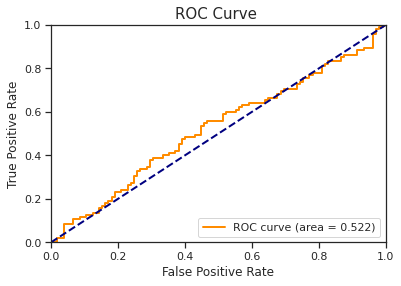

In [ ]:
# Create some random data
y_random=np.random.randint(2, size=200)
y_pred_prob_random=np.random.random((200))

# Plot the ROC curve
plot_roc_curve(None, None, y_random, y_pred_prob=y_pred_prob_random, title="", plot=True, sample_weight=None)
plt.show()

The blue dotted line indicates what true random performance would look like, in our sample of 200 it wiggles either side of this, but we can see that's not predictive.

A perfectly predictive model would classify all true points with a probability of 1 and all other points with a probability of 0. This would look like a right angled line which shot up to the upper left corner, and then across to the upper right corner. What this curve would tell us is that for all threshold values under 1 the model is perfectly predictive and that for a threshold of 1 the model is no better than random.

Let's see how our random forest model on breast cancer performs in the validation set.

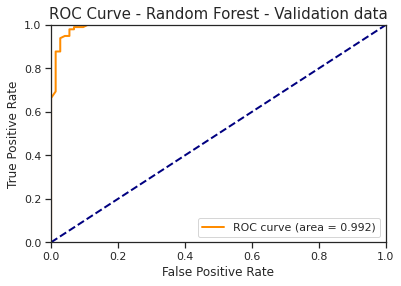

In [ ]:
plot_roc_curve(RF_model, X_val_c, y_val_c, title="- Random Forest - Validation data" )

It appears as though the random forest model is robust to different max depths, provided It's more than about 5. Let's choose 5, because choosing a smaller max depth, because will yield a simpler model that is quicker to run. Let's check the performance on the test set:

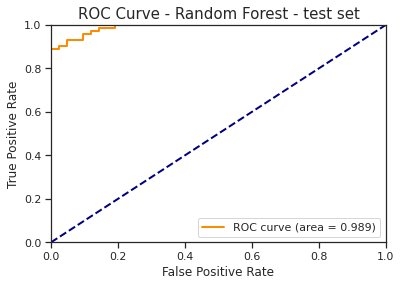

In [ ]:
RF_model_temp=RF_model = ensemble.RandomForestClassifier(n_estimators=100, min_impurity_decrease=0.1, max_depth = 5)
RF_model_temp = RF_model_temp.fit(X_train_c,y_train_c)
plot_roc_curve(RF_model, X_test_c, y_test_c, title="- Random Forest - test set")

Wow. This is an excellent score, an AU-ROC (Area under the reciever operating characteristic curver) above 0.95 is considered highly predictive. You can see it is much closer to a perfect model than random predictoins. This is the power of random forests!

## Conclusion

* Many machine learning models have are based off simple ideas that are easy to grasp
* Code implimentation is quick and easy
* Unlike linear regression, these methods can fit data of any shape quickly and easily (sometimes too easily, in the case of overfitting)
* If you need a quick and dirty prediction, you should throw a random forest at it.

## Thanks for coming!